In [424]:
%matplotlib notebook
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import pyelastix
import scipy
import skimage.feature
import math
import pycpd
import skimage

<IPython.core.display.Javascript object>


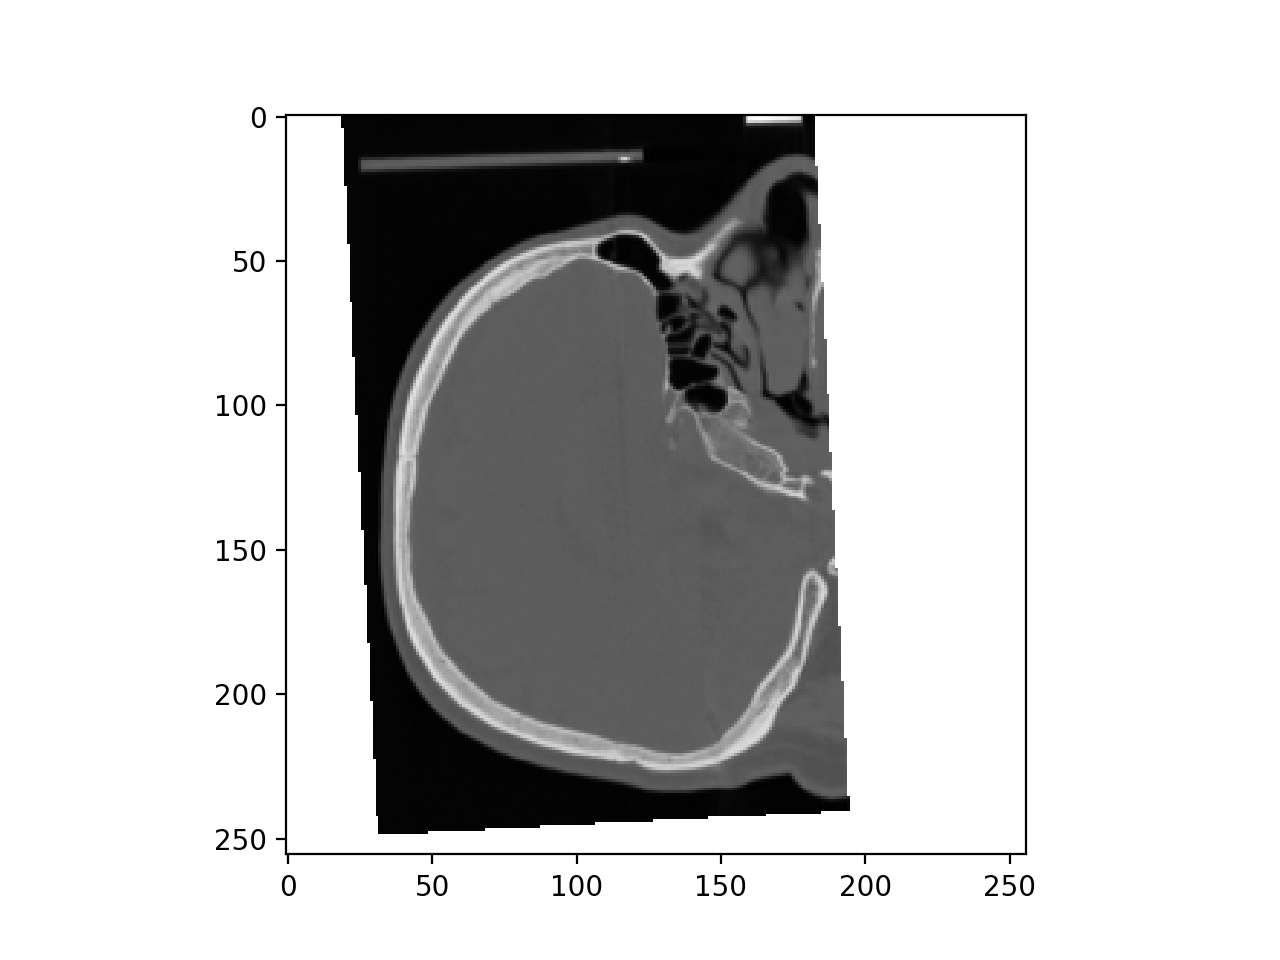

In [2]:
preopt = nib.load("../data/subject_1/preopCT_subject_1.nii")
postopt = nib.load("../data/subject_1/postopCT_subject_1.nii")
plt.imshow(preopt.get_data()[:, :, 100], cmap="gray")

In [3]:
preopt_f = flatten(preopt)
postopt_f = flatten(postopt)

# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.imshow(preopt_f, cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(postopt_f, cmap="gray")

NameError: name 'flatten' is not defined

In [443]:
MIN_PIXELS_ELECTRODE = 10

def flatten(img):
    idata = img.get_data()
    new_img = np.zeros(shape=(idata.shape[0], idata.shape[1]))
    for i in range(idata.shape[2]):
        new_img += idata[:, :, i]
    new_img /= idata.shape[2]
    return new_img

def plot_preopt_fluoro(preopt_filename, postopt_filename, fluoro_filename):
    preopt = nib.load(preopt_filename)
    postopt = nib.load(postopt_filename)
    fluoro = Image.open(fluoro_filename)
    preopt_f = flatten(preopt)
    postopt_f = flatten(postopt)
    
    print(fluoro.size)
    
    fig = plt.figure(figsize=(8,6))
    fig.subplots_adjust(wspace=0.4)
    
    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(preopt_f, cmap="gray")
    
    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(fluoro, cmap="gray")
    text = ax.text(0, 0, "", va="bottom", ha="left")
    
    ax = fig.add_subplot(2, 2, 3)
    ax.imshow(postopt_f, cmap="gray")
    
    def click_handle(event):
        text.set_text("button: %f, %f" % (event.xdata, event.ydata))
        
    fig.canvas.mpl_connect("button_press_event", click_handle)

def plot_hull_electrodes_fluoro(hull_file, electrodes_file, fluoro_file, tr):
    fluoro = Image.open(fluoro_file)
    fluoro = tr.transform_fluoro(fluoro)
    
    hull = nib.load(hull_file)
    hull_f = flatten(hull)
    electrodes = nib.load(electrodes_file)
    electrodes_f = flatten(electrodes)
    
    fig = plt.figure(figsize=(8,6))
    fig.subplots_adjust(wspace=0.4)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(hull_f, alpha=0.5, cmap="gray")
    ax.imshow(electrodes_f, alpha=0.5, cmap="gray")
    
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(fluoro, cmap="gray")
    text = ax.text(0, 0, "", va="bottom", ha="left")
    
    def click_handle(event):
        text.set_text("button: %f, %f" % (event.xdata, event.ydata))
        
    fig.canvas.mpl_connect("button_press_event", click_handle)
    
def plot_figures(preopt_f, fluoro, ct_lm=[]):
    fig = plt.figure(figsize=(8,6))
    fig.subplots_adjust(wspace=0.4)
    
    ax = fig.add_subplot(2, 2, 1)
    ax.imshow(preopt_f, cmap="gray")
    
    ax = fig.add_subplot(2, 2, 2)
    ax.imshow(fluoro, cmap="gray")
    text = ax.text(0, 0, "", va="bottom", ha="left")
    
    ax = fig.add_subplot(2, 2, 3)
    ax.set_xlim([0, 250])
    ax.set_ylim([250, 0])
    ax.imshow(preopt_f, alpha=0.2, cmap="Reds")
    ax.imshow(fluoro, alpha=0.2, cmap="gray")
    for cl in ct_lm:
        cir = plt.Circle((cl[1], cl[0]), 3, color="r")
        ax.add_artist(cir)
    
    preopt_f = skimage.feature.canny(preopt_f, sigma=2)
    ax = fig.add_subplot(2, 2, 4)
    ax.set_xlim([0, 250])
    ax.set_ylim([250, 0])
    ax.imshow(preopt_f, alpha=0.2, cmap="Reds")
    ax.imshow(fluoro, alpha=0.2, cmap="gray")
    
    def click_handle(event):
        text.set_text("button: %f, %f" % (event.xdata, event.ydata))
        
    fig.canvas.mpl_connect("button_press_event", click_handle)

def register(preopt_filename, fluoro_filename, tr, ct_lm=[]):
    preopt = nib.load(preopt_filename)
    fluoro = Image.open(fluoro_filename)
    
    preopt_f = flatten(preopt)
    fluoro = tr.transform_fluoro(fluoro)
    
    plot_figures(preopt_f, fluoro, ct_lm)
    
class Transform:
    def __init__(self, size, rotate, shiftleft, shiftdown, transform=None):
        self.size = size
        self.rotate = rotate
        self.shiftleft = shiftleft
        self.shiftdown = shiftdown
        self.transform = transform
    
    def get_affine_transform(self):
        if self.transform is None:
            return (1, 0, self.shiftleft, 0, 1, -self.shiftdown)
        a = self.transform[0][0]
        b = self.transform[0][1]
        d = self.transform[1][0]
        e = self.transform[1][1]
        return (a, b, 0, d, e, 0)
    
    def transform_fluoro(tr, fluoro):
        eparams = pyelastix.get_default_params()
        #fluoro_d, field = pyelastix.register(np.array(fluoro), preopt_f, eparams)
        fluoro.thumbnail(tr.size)
        fluoro = fluoro.rotate(tr.rotate)
        shiftx = tr.shiftleft
        shifty = tr.shiftdown
        fluoro = ImageOps.expand(fluoro, (0, shiftx, 0, shifty))
        # transform data (a,b,c,d,e,f) = (ax*by+c, dx+ey+f)
        #fluoro = fluoro.transform(fluoro.size, Image.AFFINE, (1, 0, shiftx, 0, 1, -shifty))
        fluoro = fluoro.transform(fluoro.size, Image.AFFINE, tr.get_affine_transform())
        return fluoro

def plot_electrodes(hull_file, electrode_coords, electrode_radius):
    hull = nib.load(hull_file)
    slices = hull.get_data()
    ln = slices.shape[2]
    electrode_slices = {"left": {}, "right": {}}
    for i in range(ln):
        slic = slices[:, :, i]
        edges = skimage.feature.canny(slic)
        slic = scipy.ndimage.binary_fill_holes(edges)
        for (j, ec) in enumerate(electrode_coords["left"]):
            if j in electrode_slices["left"]:
                continue
            ec_slic = slic[ec[0] - electrode_radius : ec[0] + electrode_radius, ec[1] - electrode_radius : ec[1] + electrode_radius]
            if np.sum(ec_slic) > MIN_PIXELS_ELECTRODE:
                electrode_slices["left"][j] = i
    for ix in range(ln):
        i = ln - ix - 1
        slic = slices[:, :, i]
        edges = skimage.feature.canny(slic)
        slic = scipy.ndimage.binary_fill_holes(edges)
        for (j, ec) in enumerate(electrode_coords["right"]):
            if j in electrode_slices["right"]:
                continue
            ec_slic = slic[ec[0] - electrode_radius : ec[0] + electrode_radius, ec[1] - electrode_radius : ec[1] + electrode_radius]
            if np.sum(ec_slic) > MIN_PIXELS_ELECTRODE:
                electrode_slices["right"][j] = i
    
    electrode_arr = np.zeros(hull.shape)
    for side in ["left", "right"]:
        for ix in electrode_slices[side]:
            es = electrode_slices[side][ix]
            xy_coords = electrode_coords[side][ix]
            draw_sphere(electrode_arr, (xy_coords[0], xy_coords[1], es), electrode_radius)
    nii = nib.Nifti1Image(electrode_arr, np.eye(4))
    return nii

def draw_sphere(arr, coords, radius):
    # https://stackoverflow.com/questions/53326570/how-to-create-sphere-inside-a-ndarray-python?noredirect=1&lq=1
    for x in range(coords[0] - radius, coords[0] + radius + 1):
        for y in range(coords[1] - radius, coords[1] + radius + 1):
            for z in range(coords[2] - radius, coords[2] + radius + 1):
                deb = radius - abs(coords[0] - x) - abs(coords[1] - y) - abs(coords[2] - z)
                if deb >= 0:
                    arr[x,y,z] = 1

def save_electrodes_arr(nii, filename):
    nii.to_filename(filename)

def get_transform(preopt_filename, fluoro_filename, reg_coords):
    preopt = nib.load(preopt_filename)
    fluoro = Image.open(fluoro_filename)
    preopt_f = flatten(preopt)
    size = fluoro.size
    
    dist1 = (((reg_coords[0][0] - reg_coords[1][0])**2) + ((reg_coords[0][1] - reg_coords[1][1])**2))**(0.5)
    dist2 = (((reg_coords[2][0] - reg_coords[3][0])**2) + ((reg_coords[2][1] - reg_coords[3][1])**2))**(0.5)
    scale = dist1 / dist2
    resize = (int(size[0] * scale), int(size[1] * scale))
    fluoro.thumbnail(resize)
    print(resize)
    
    m1 = slope(reg_coords[0], reg_coords[1])
    m2 = slope(reg_coords[2], reg_coords[3])
    rad_angle = np.arctan((m1 - m2) / (1 + (m2 * m1)))
    angle = math.degrees(rad_angle)
    
    # https://en.wikipedia.org/wiki/Rotation_matrix
    x_scaled = reg_coords[3][1] * scale
    y_scaled = reg_coords[3][0] * scale
    x_rot = (x_scaled * math.cos(rad_angle)) + (x_scaled * math.sin(rad_angle))
    y_rot = (y_scaled * math.cos(rad_angle)) - (y_scaled * math.sin(rad_angle))
    
    move_down = reg_coords[1][0] - y_rot
    move_left = reg_coords[1][1] - x_rot
    
    start = np.array([list(reg_coords[0]), list(reg_coords[1])])
    end = np.array([list(reg_coords[2]), list(reg_coords[3])]) * scale
    trans = np.dot(np.linalg.inv(end), start)
    #trans_t = (trans[0][0], trans[1][0], 0, trans[0][1], trans[1][1], 0)
    #trans_t = (trans[0][0], trans[0][1], 0, trans[1][0], trans[1][1], 0)
    trans_t = (trans[0][1], trans[1][1], move_left, trans[0][0], trans[1][0], -move_down)
    fluoro = fluoro.transform(fluoro.size, Image.AFFINE, trans_t)
    
    plot_figures(preopt_f, fluoro)
    
def get_scale_resize(reg_coords, size):
    dist1 = (((reg_coords[0][0] - reg_coords[1][0])**2) + ((reg_coords[0][1] - reg_coords[1][1])**2))**(0.5)
    dist2 = (((reg_coords[2][0] - reg_coords[3][0])**2) + ((reg_coords[2][1] - reg_coords[3][1])**2))**(0.5)
    scale = dist1 / dist2
    resize = (int(size[0] * scale), int(size[1] * scale))
    return (scale, resize)

def slope(p1, p2):
    return (p2[0] - p1[0]) / (p2[1] - p1[1])

def distance(c1, c2):
    return (((c1[0] - c2[0])**2) + ((c1[1] - c2[1])**2))**0.5

def plot_hull_slices(hull_file, slice_index):
    hull = nib.load(hull_file)
    slices = hull.get_data()
    slic = slices[:, :, slice_index]
    
    fig = plt.figure(figsize=(8,6))
    fig.subplots_adjust(wspace=0.4)
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(slic, cmap="gray")
    
    edges = skimage.feature.canny(slic)
    slic = scipy.ndimage.binary_fill_holes(edges)
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(slic, cmap="gray")

(3247, 2598)


<IPython.core.display.Javascript object>


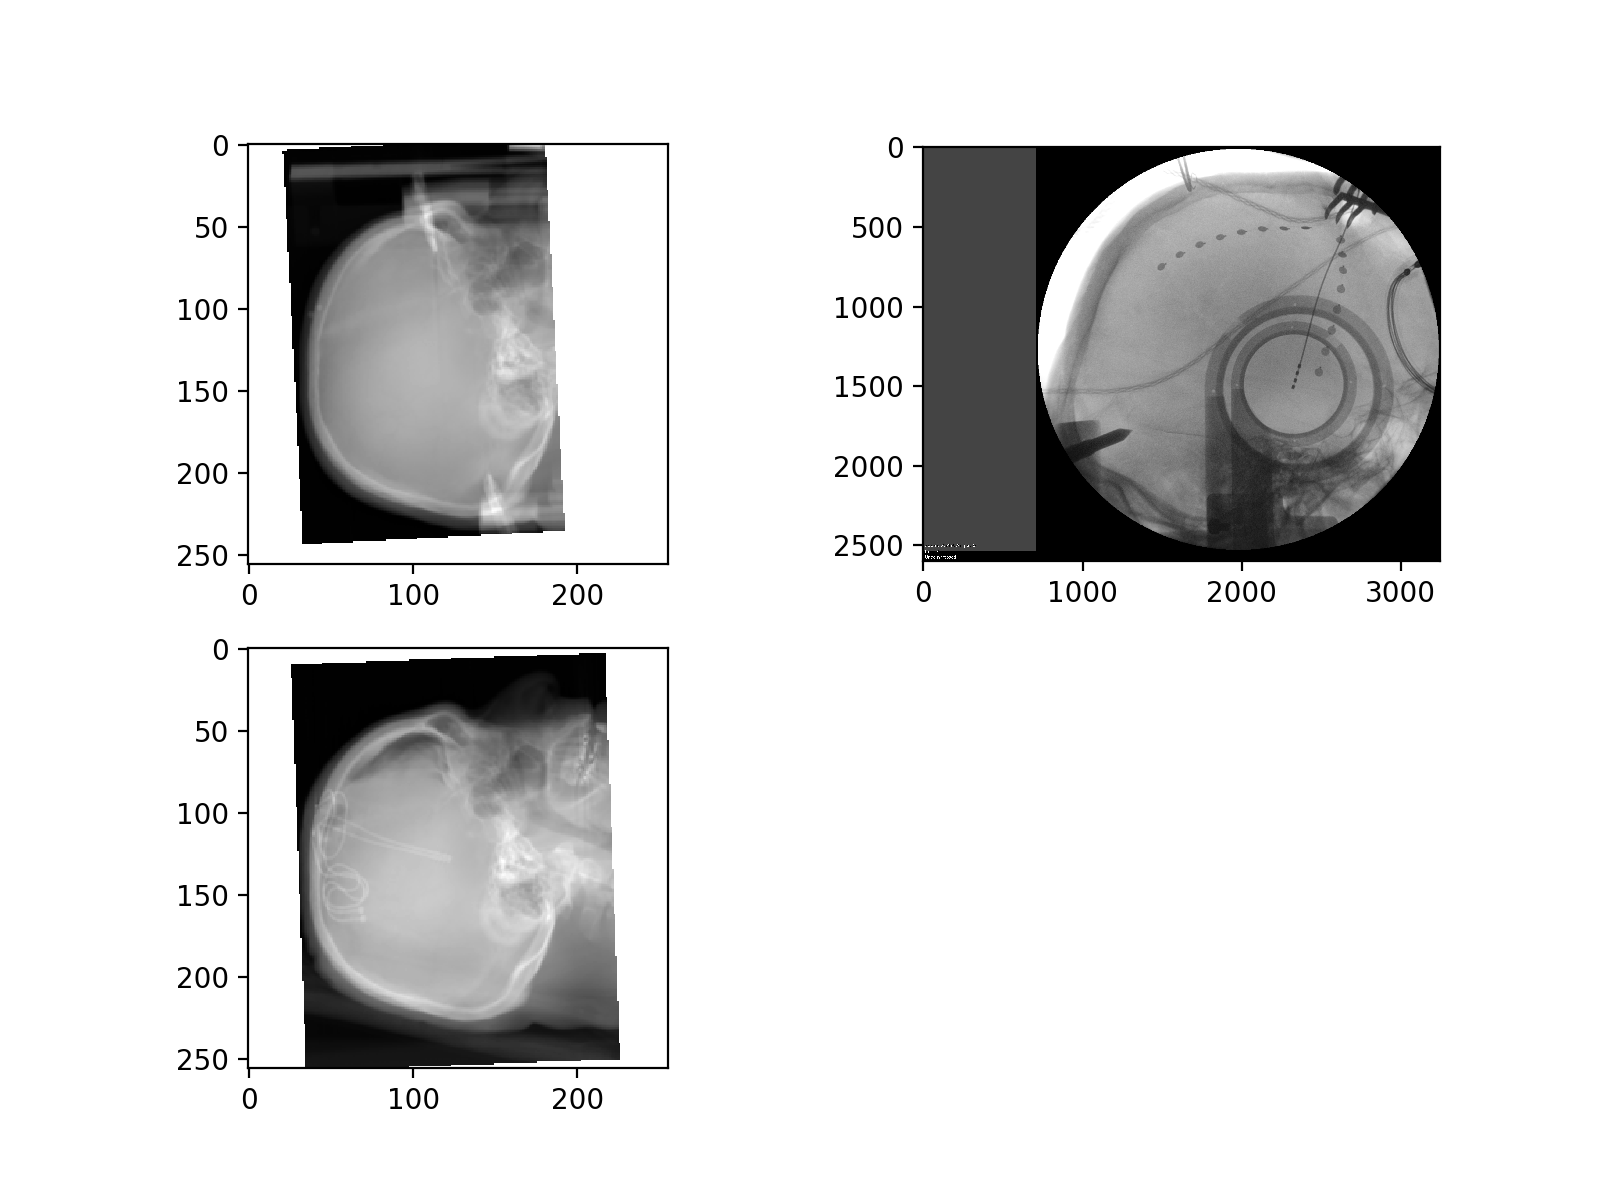

(0.0723152282050146, (234, 187))


<IPython.core.display.Javascript object>


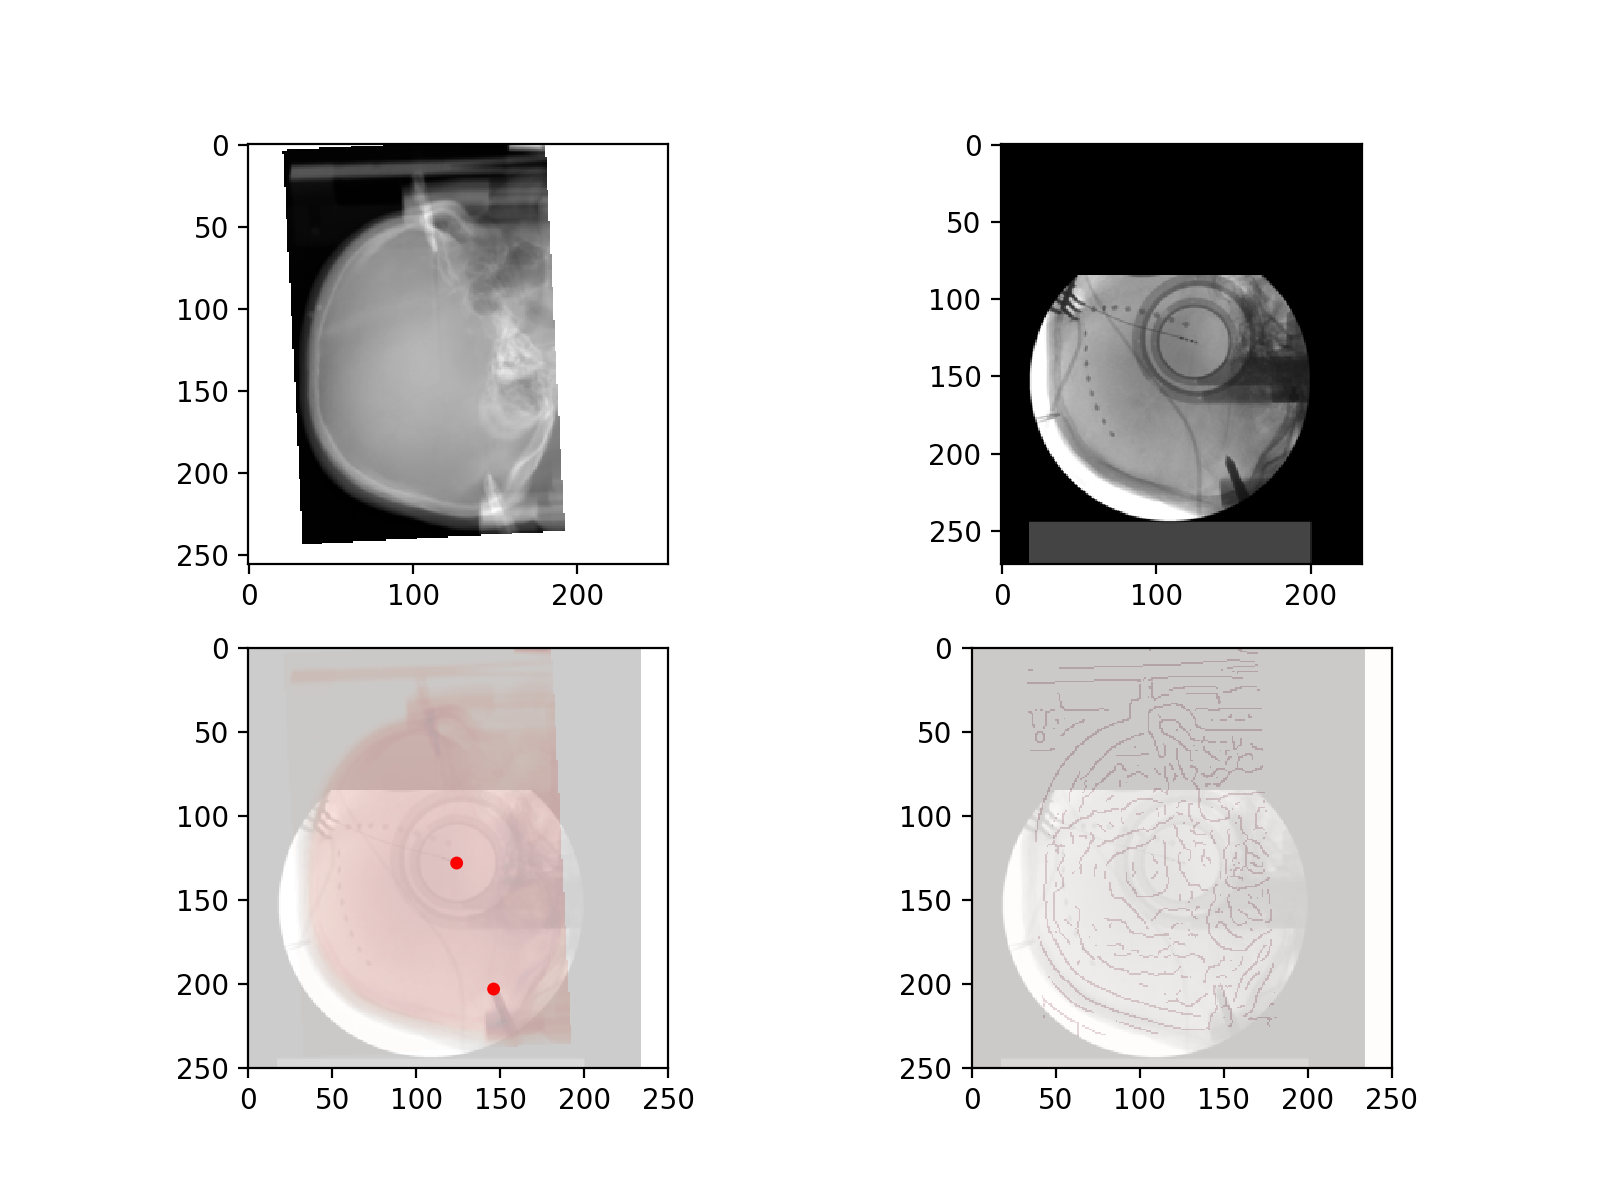

back pin tip 2.0
end of dbs electrode 5.0


<IPython.core.display.Javascript object>


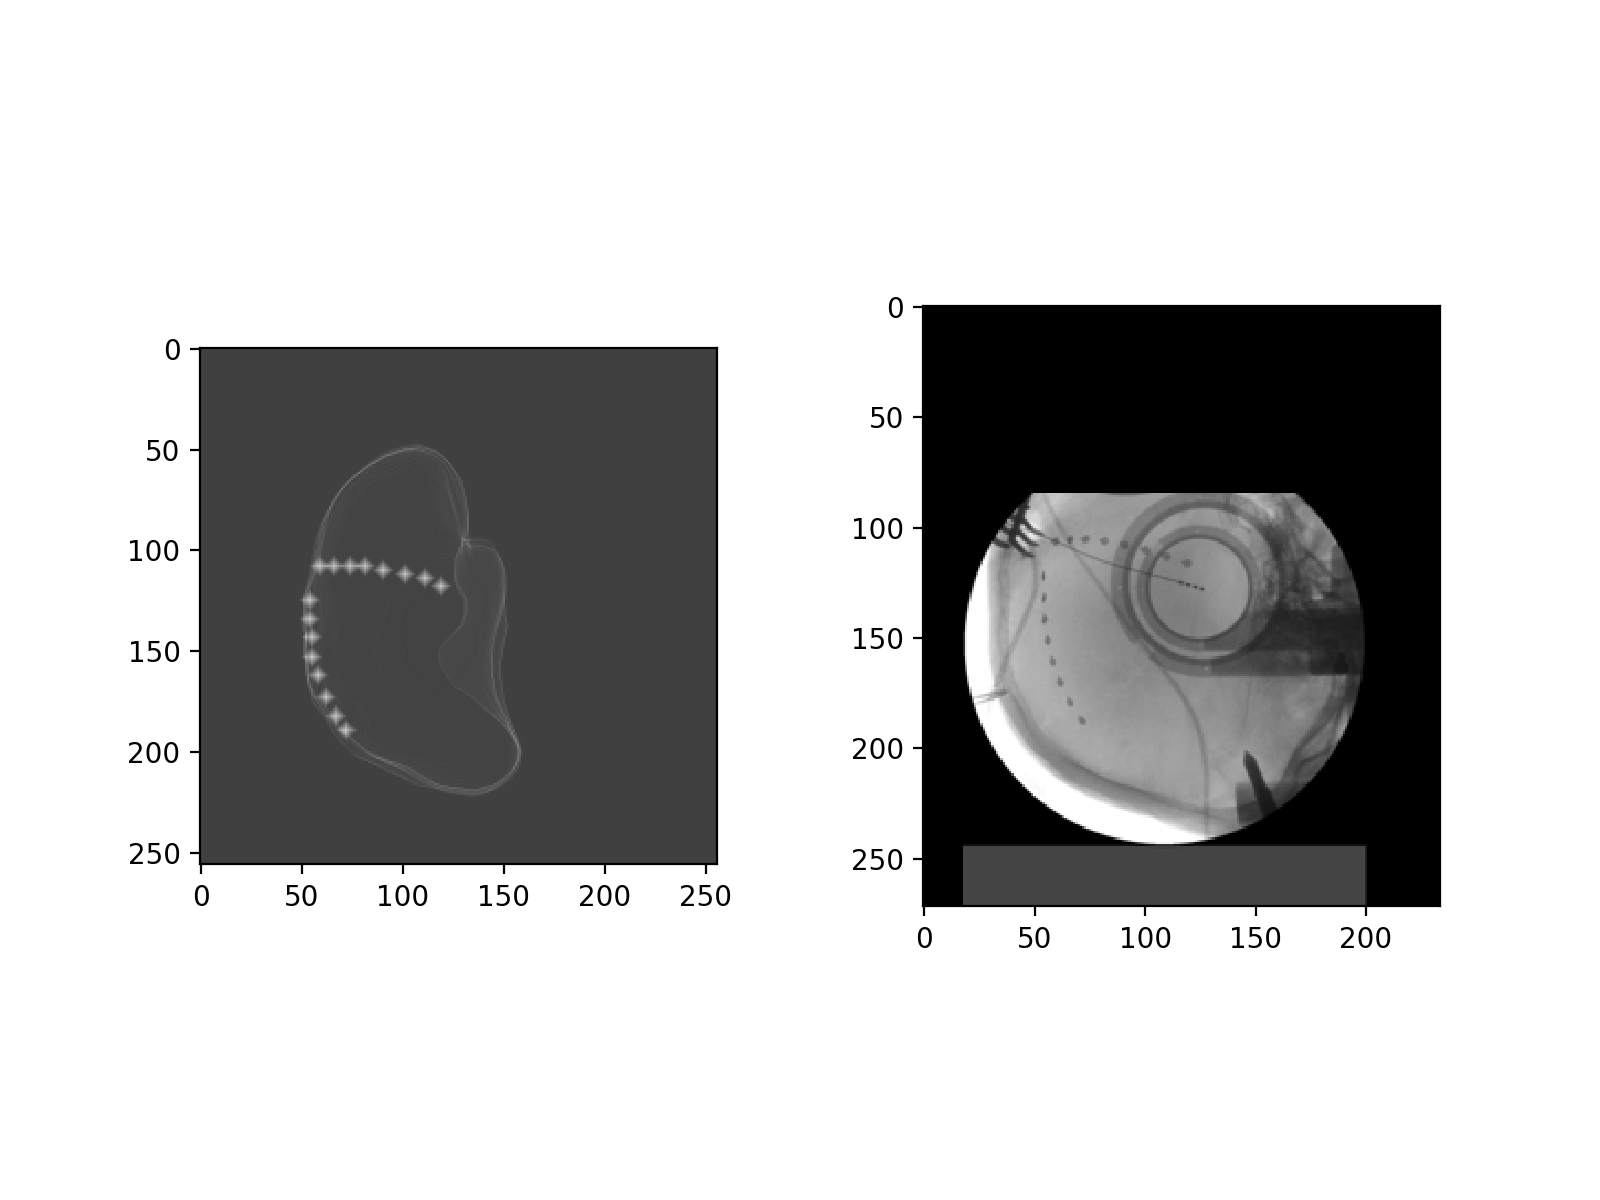

In [444]:
plot_preopt_fluoro("../data/subject_1/preopCT_subject_1.nii", "../data/subject_1/postopCT_subject_1.nii", "../data/subject_1/fluoro_subject_1.jpg")
reg_coords = [(203, 146), (129, 124), (1801, 1294), (1524, 2325)]
print(get_scale_resize(reg_coords, (3247, 2598)))

tr = Transform(size=(234, 187), rotate=90, shiftleft=5, shiftdown=80)
register(
    "../data/subject_1/preopCT_subject_1.nii",
    "../data/subject_1/fluoro_subject_1.jpg",
    tr,
    [(203, 146), (128, 124)]
)

electrodes = {
    "left": [(189, 72), (182, 67), (173, 62), (162, 58), (153, 55), (143, 55), (134, 54), (125, 54)],
    "right": [(118, 119), (114, 111), (112, 101), (110, 90), (108, 81), (108, 74), (108, 66), (108, 59)],
}

electrodes_arr = plot_electrodes("../data/subject_1/hull_subject_1.nii", electrodes, 5)
save_electrodes_arr(electrodes_arr, "../data/subject_1/electrodes.nii")
print("back pin tip", distance((203, 146), (205, 146)))
print("end of dbs electrode", distance((128, 124), (132, 127)))
plot_hull_electrodes_fluoro(
    "../data/subject_1/hull_subject_1.nii",
    "../data/subject_1/electrodes.nii",
    "../data/subject_1/fluoro_subject_1.jpg",
    tr
)

(1280, 1024)


<IPython.core.display.Javascript object>


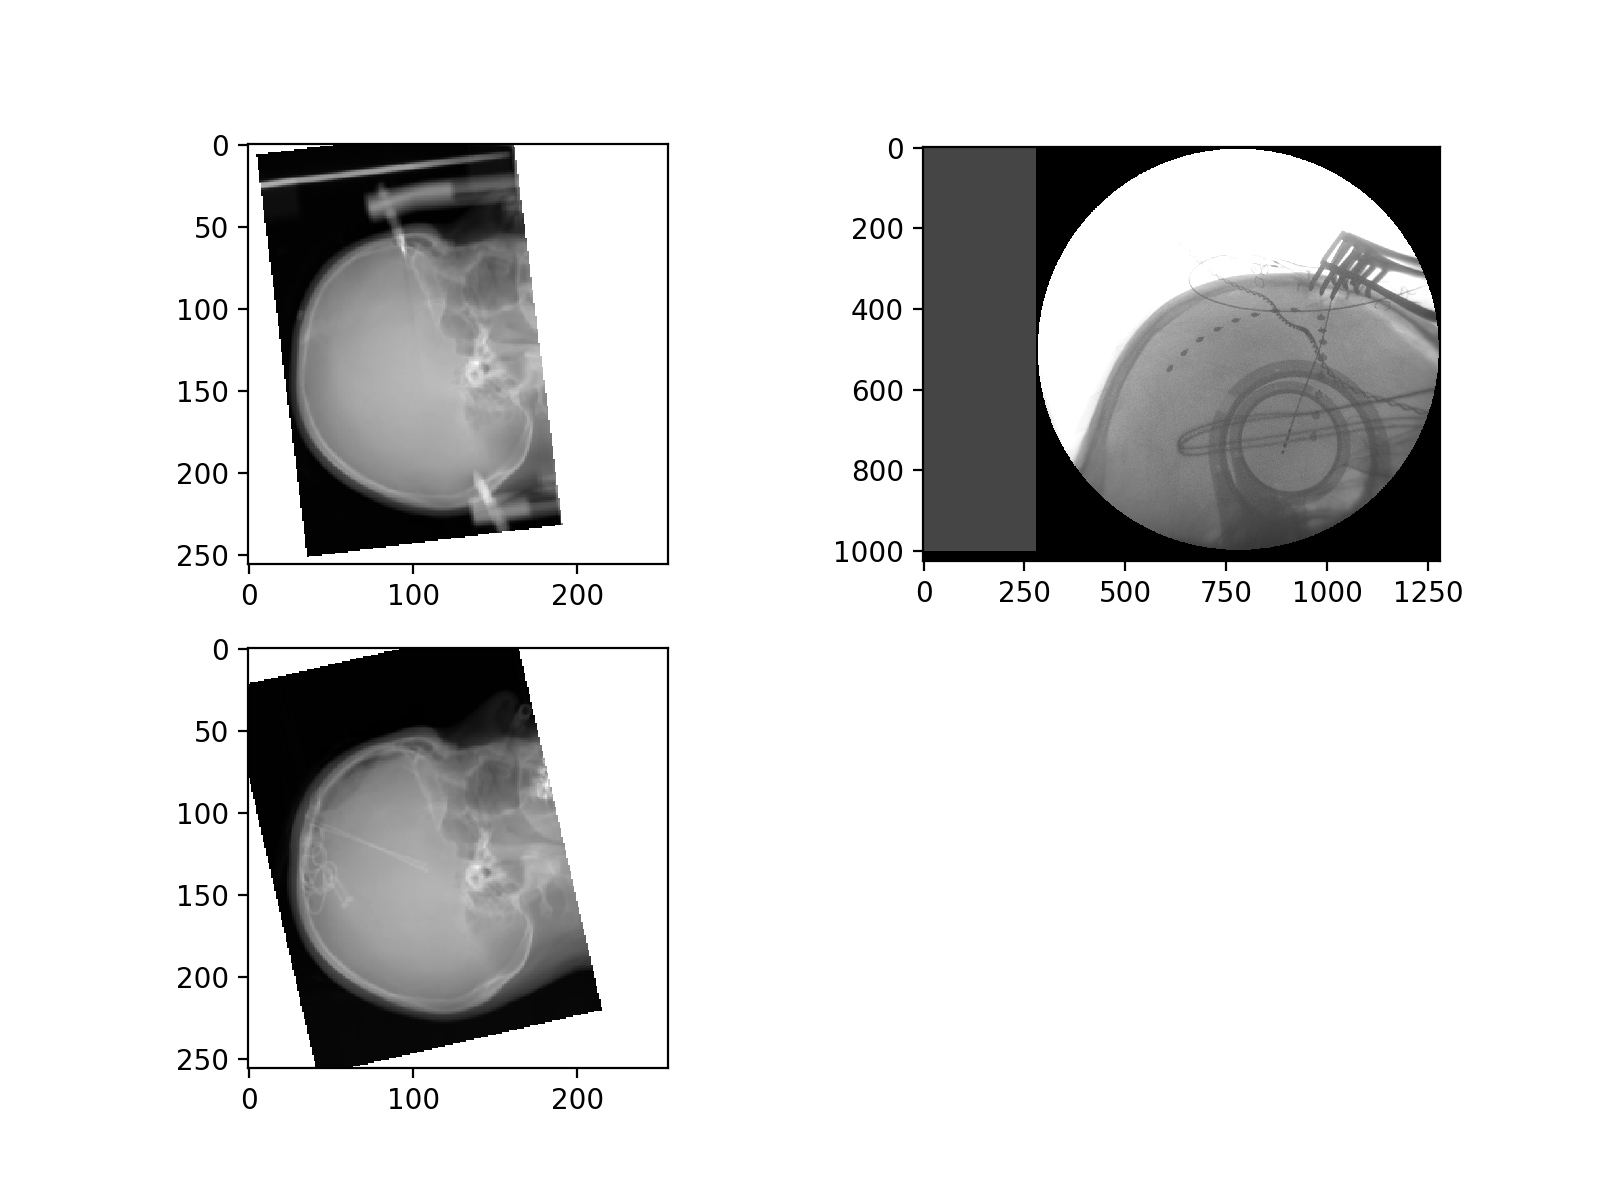

(0.17176705822922736, (219, 175))


<IPython.core.display.Javascript object>


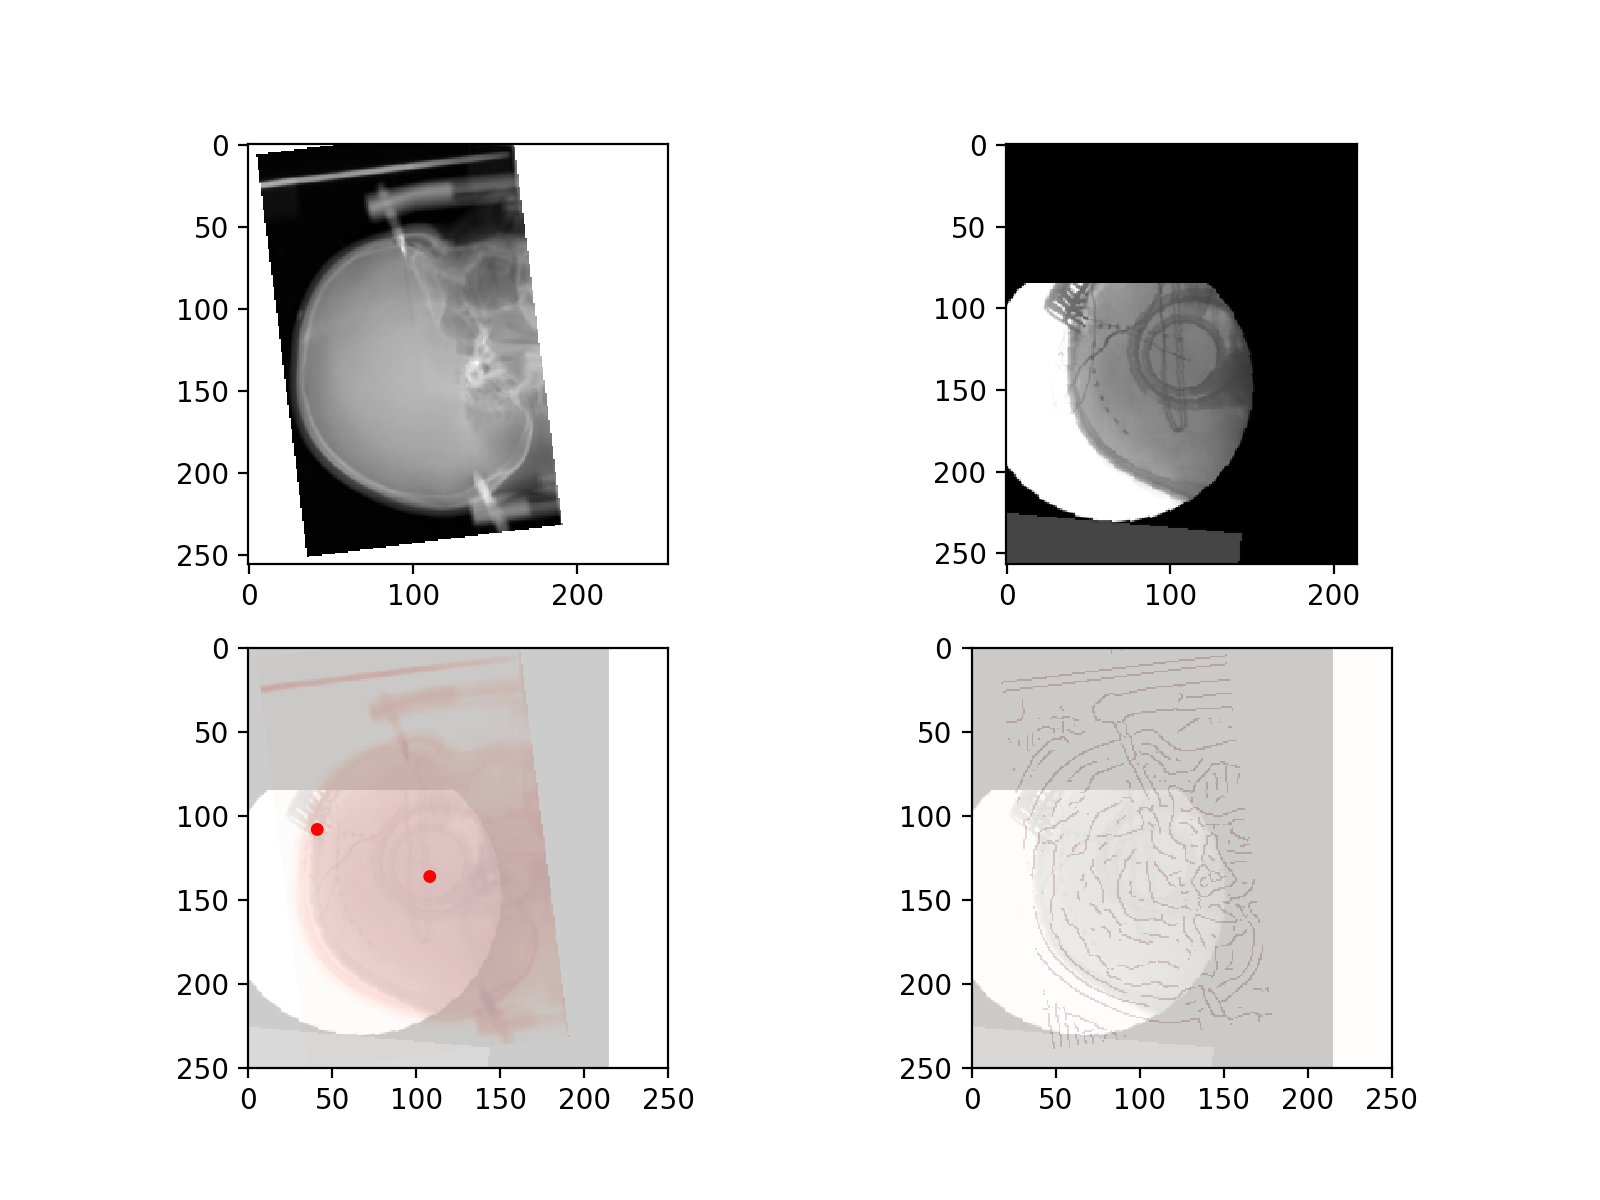

top of dbs electrode 3.605551275463989
end of dbs electrode 3.605551275463989


<IPython.core.display.Javascript object>


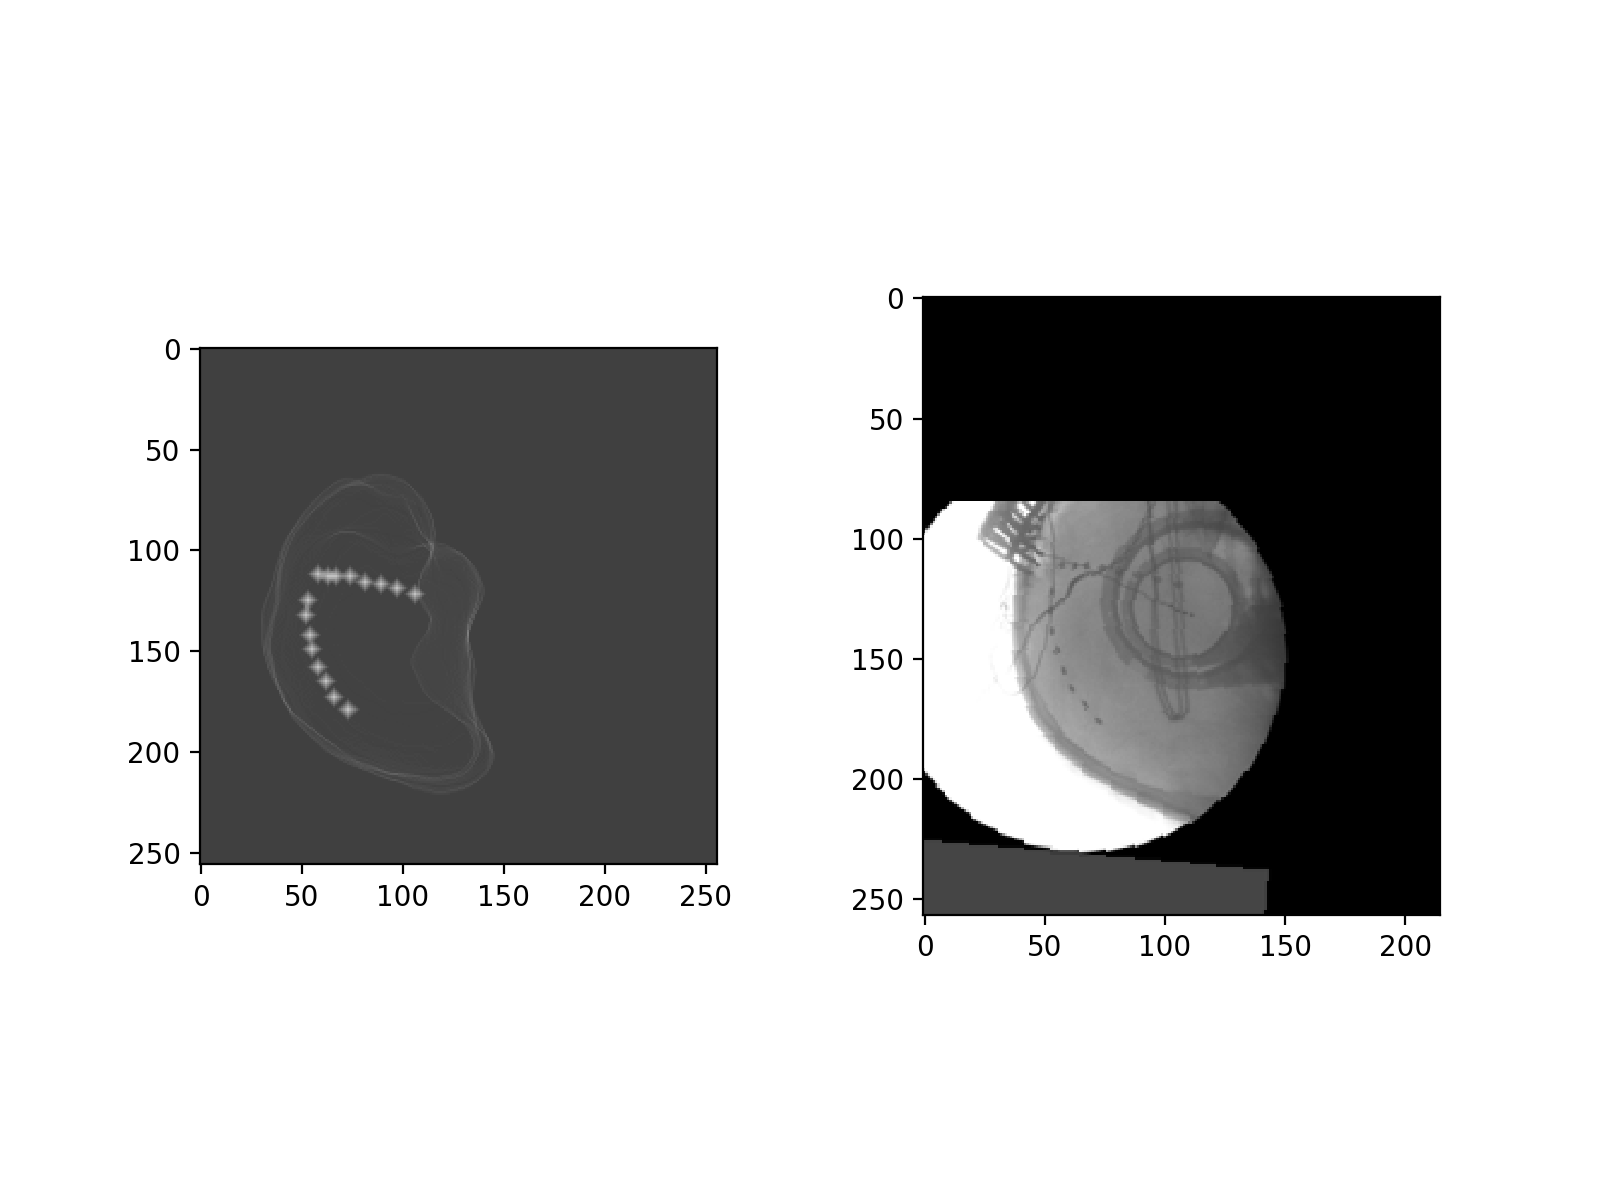

In [445]:
plot_preopt_fluoro("../data/subject_2/preopCT_subject_2.nii", "../data/subject_2/postopCT_subject_2.nii", "../data/subject_2/fluoro_subject_2b.jpg")
reg_coords = [(108, 41), (136, 108), (343, 995), (754, 896)]
print(get_scale_resize(reg_coords, (1280, 1024)))

tr = Transform(size=(215, 172), rotate=85, shiftleft=40, shiftdown=45)
register(
    "../data/subject_2/preopCT_subject_2.nii",
    "../data/subject_2/fluoro_subject_2b.jpg",
    tr,
    [(108, 41), (136, 108)]
)
electrodes = {
    "left": [(179, 73), (173, 66), (165, 62), (158, 58), (149, 55), (142, 54), (132, 52), (125, 53)],
    "right": [(122, 106), (119, 97), (117, 89), (116, 81), (113, 74), (113, 67), (113, 63), (112, 58)],
}
electrodes_arr = plot_electrodes("../data/subject_2/hull_subject_2.nii", electrodes, 5)
save_electrodes_arr(electrodes_arr, "../data/subject_2/electrodes.nii")
print("top of dbs electrode", distance((108, 41), (105, 43)))
print("end of dbs electrode", distance((136, 108), (134, 111)))
plot_hull_electrodes_fluoro(
    "../data/subject_2/hull_subject_2.nii",
    "../data/subject_2/electrodes.nii",
    "../data/subject_2/fluoro_subject_2b.jpg",
    tr
)

(1280, 1024)


<IPython.core.display.Javascript object>


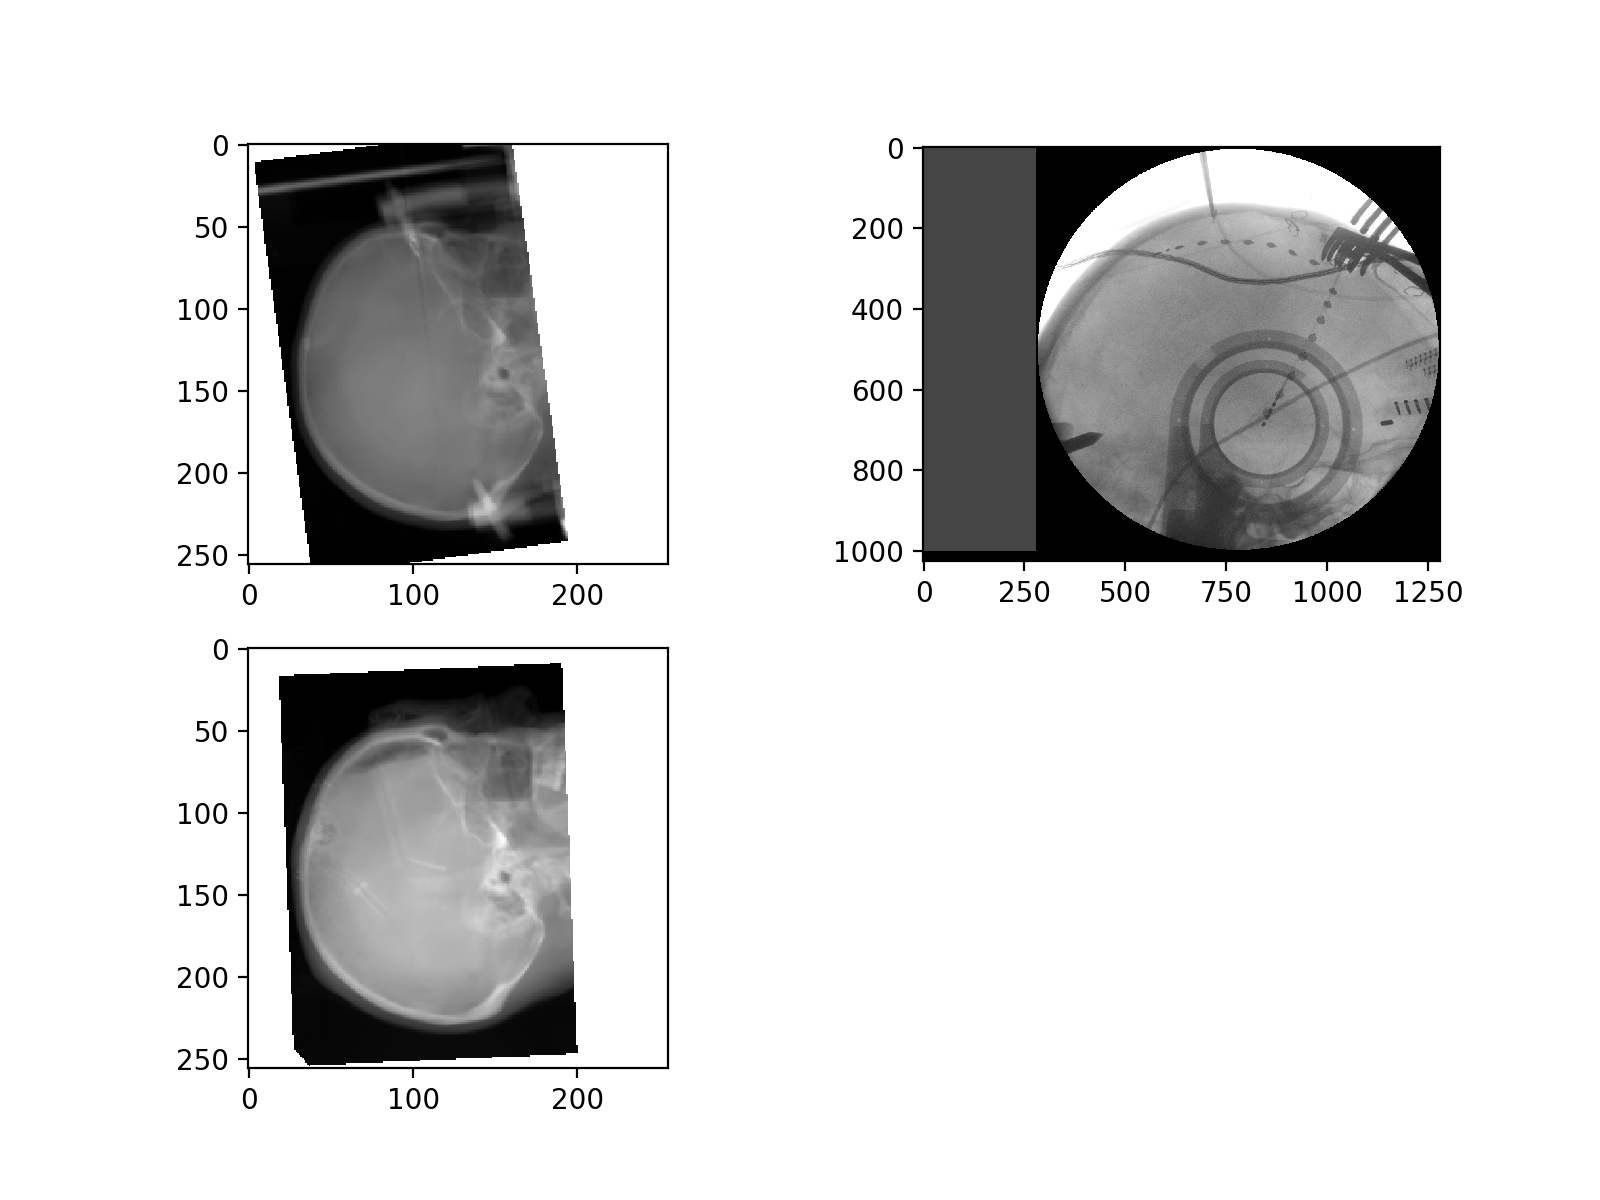

(0.17627013557257795, (225, 180))


<IPython.core.display.Javascript object>


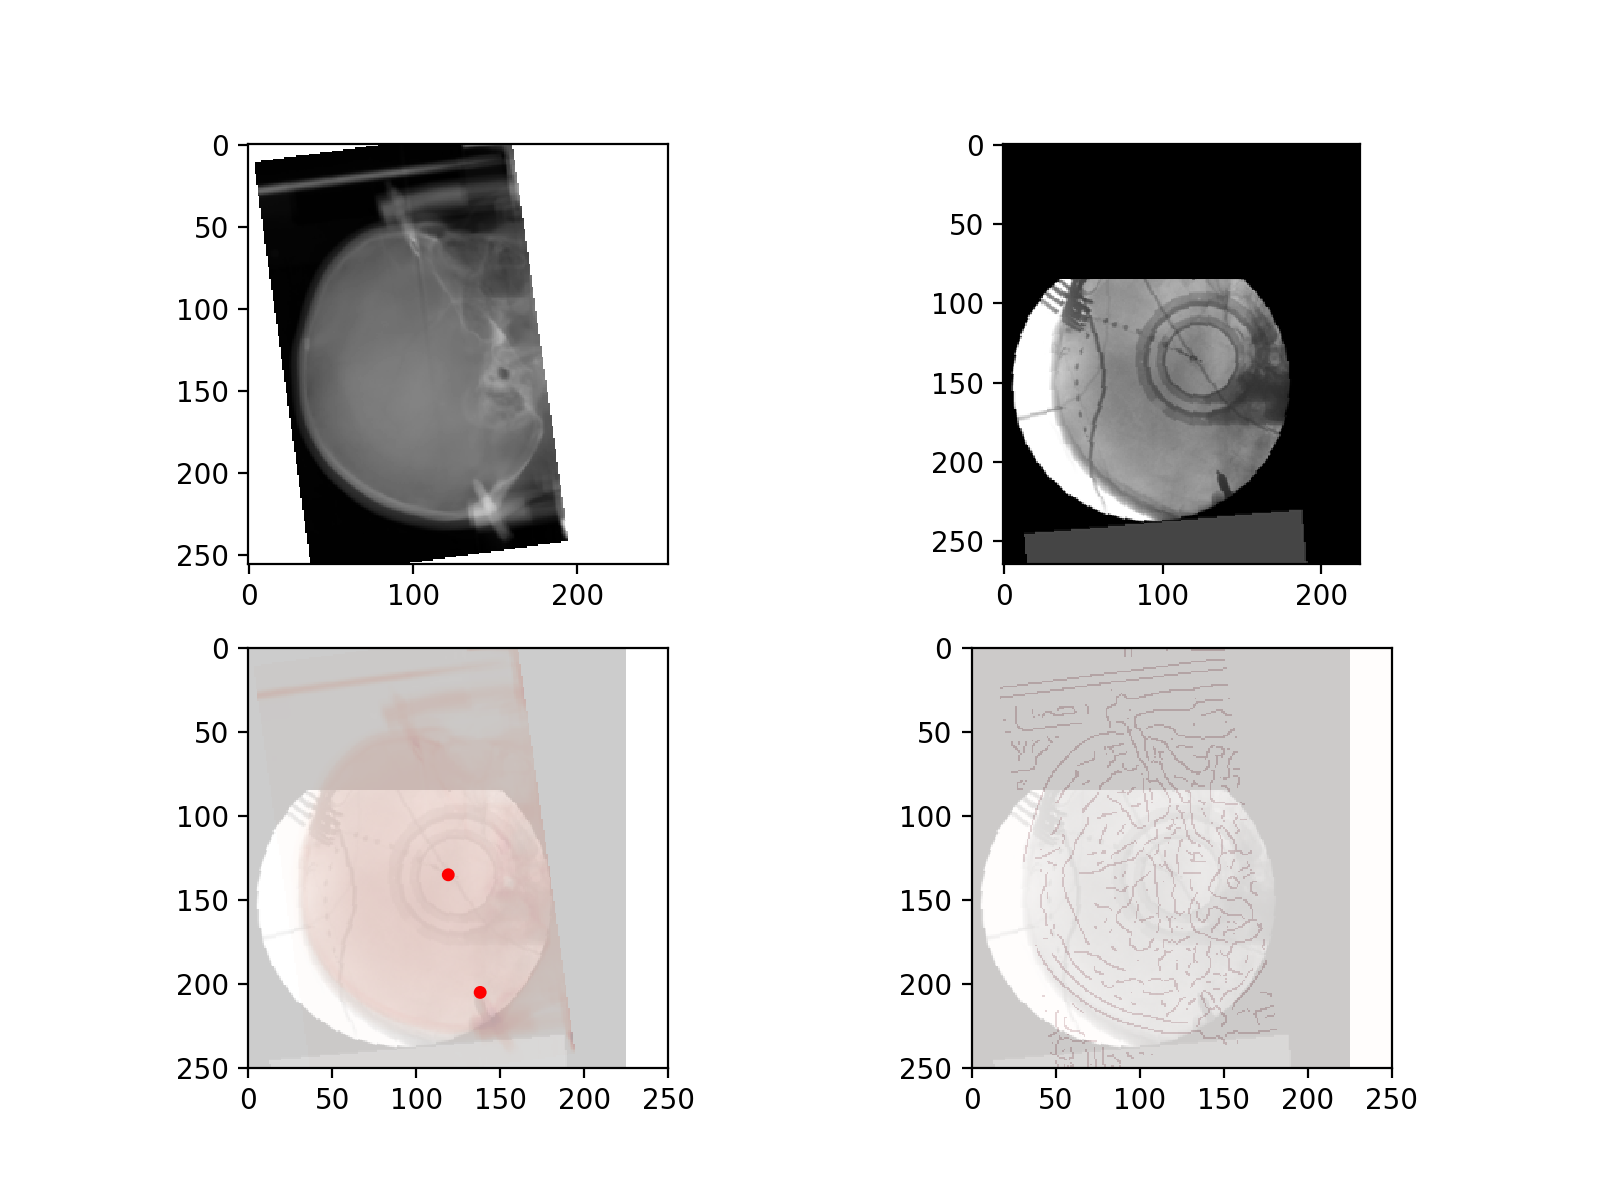

back pin tip 4.242640687119285
dbs electrode end 6.708203932499369


<IPython.core.display.Javascript object>


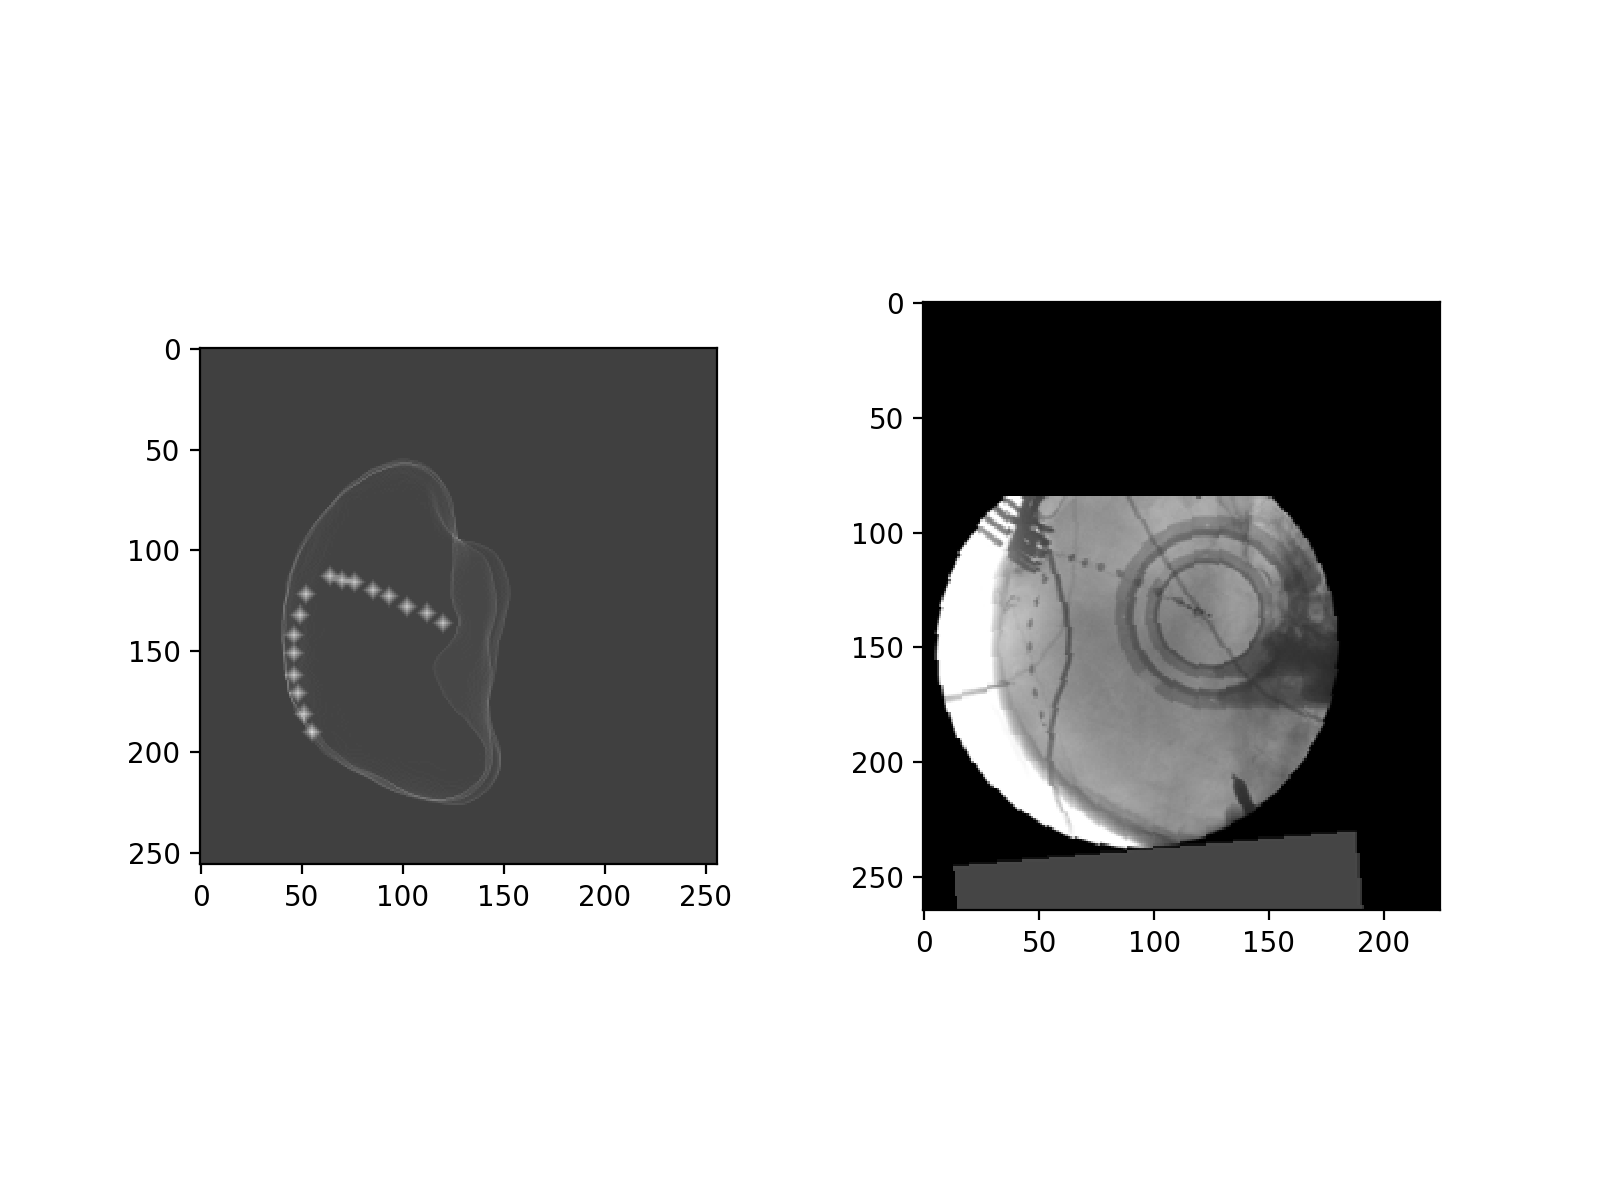

In [446]:
plot_preopt_fluoro("../data/subject_3/preopCT_subject_3.nii", "../data/subject_3/postopCT_subject_3.nii", "../data/subject_3/fluoro_subject_3.jpg")
reg_coords = [(205, 138), (135, 119), (713, 436), (693, 847)]
print(get_scale_resize(reg_coords, (1280, 1024)))

tr = Transform(size=(225, 180), rotate=95, shiftleft=15, shiftdown=70)
register(
    "../data/subject_3/preopCT_subject_3.nii",
    "../data/subject_3/fluoro_subject_3.jpg",
    tr,
    [(205, 138), (135, 119)]
)
electrodes = {
    "left": [(190, 55), (181, 51), (171, 48), (162, 46), (151, 46), (142, 46), (132, 49), (122, 52)],
    "right": [(136, 120), (131, 112), (128, 102), (123, 93), (120, 85), (116, 76), (115, 70), (113, 64)],
}
electrodes_arr = plot_electrodes("../data/subject_3/hull_subject_3.nii", electrodes, 5)
save_electrodes_arr(electrodes_arr, "../data/subject_3/electrodes.nii")
print("back pin tip", distance((205, 138), (208, 135)))
print("dbs electrode end", distance((135, 119), (138, 125)))
plot_hull_electrodes_fluoro(
    "../data/subject_3/hull_subject_3.nii",
    "../data/subject_3/electrodes.nii",
    "../data/subject_3/fluoro_subject_3.jpg",
    tr
)

(1280, 1024)


<IPython.core.display.Javascript object>


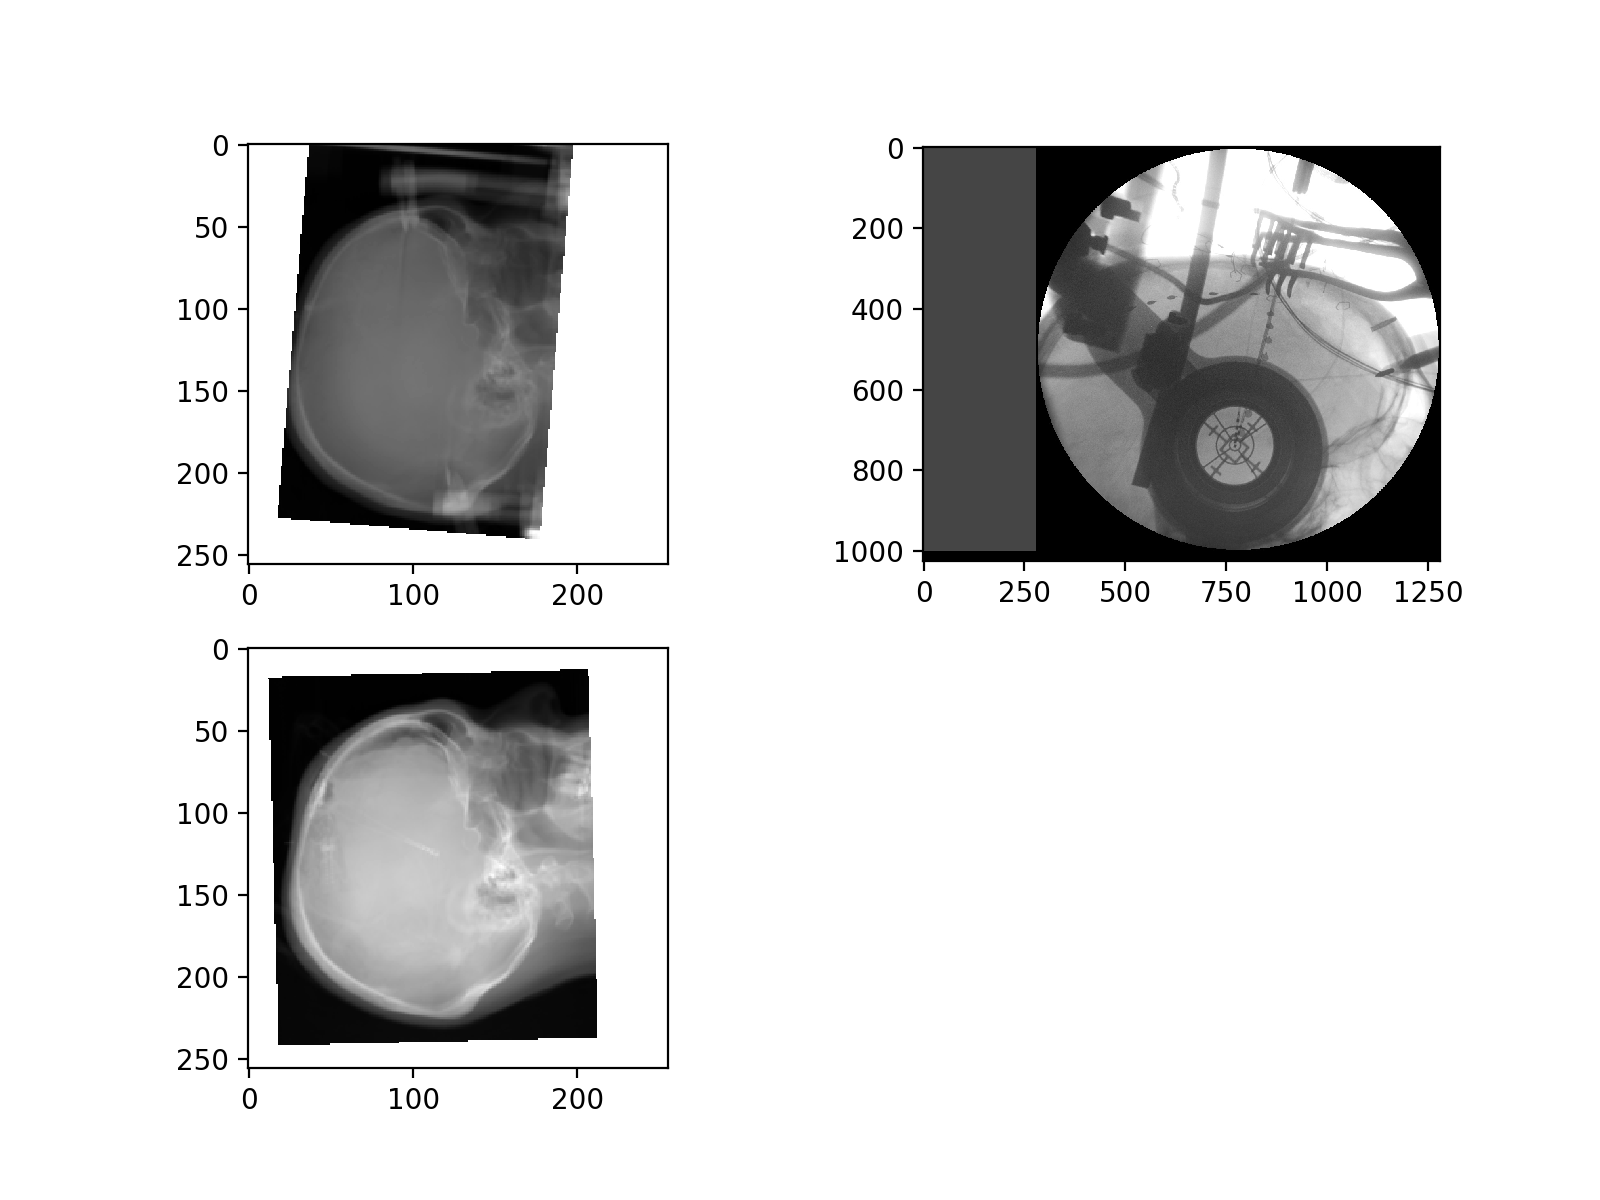

(0.19304518178735666, (247, 197))


<IPython.core.display.Javascript object>


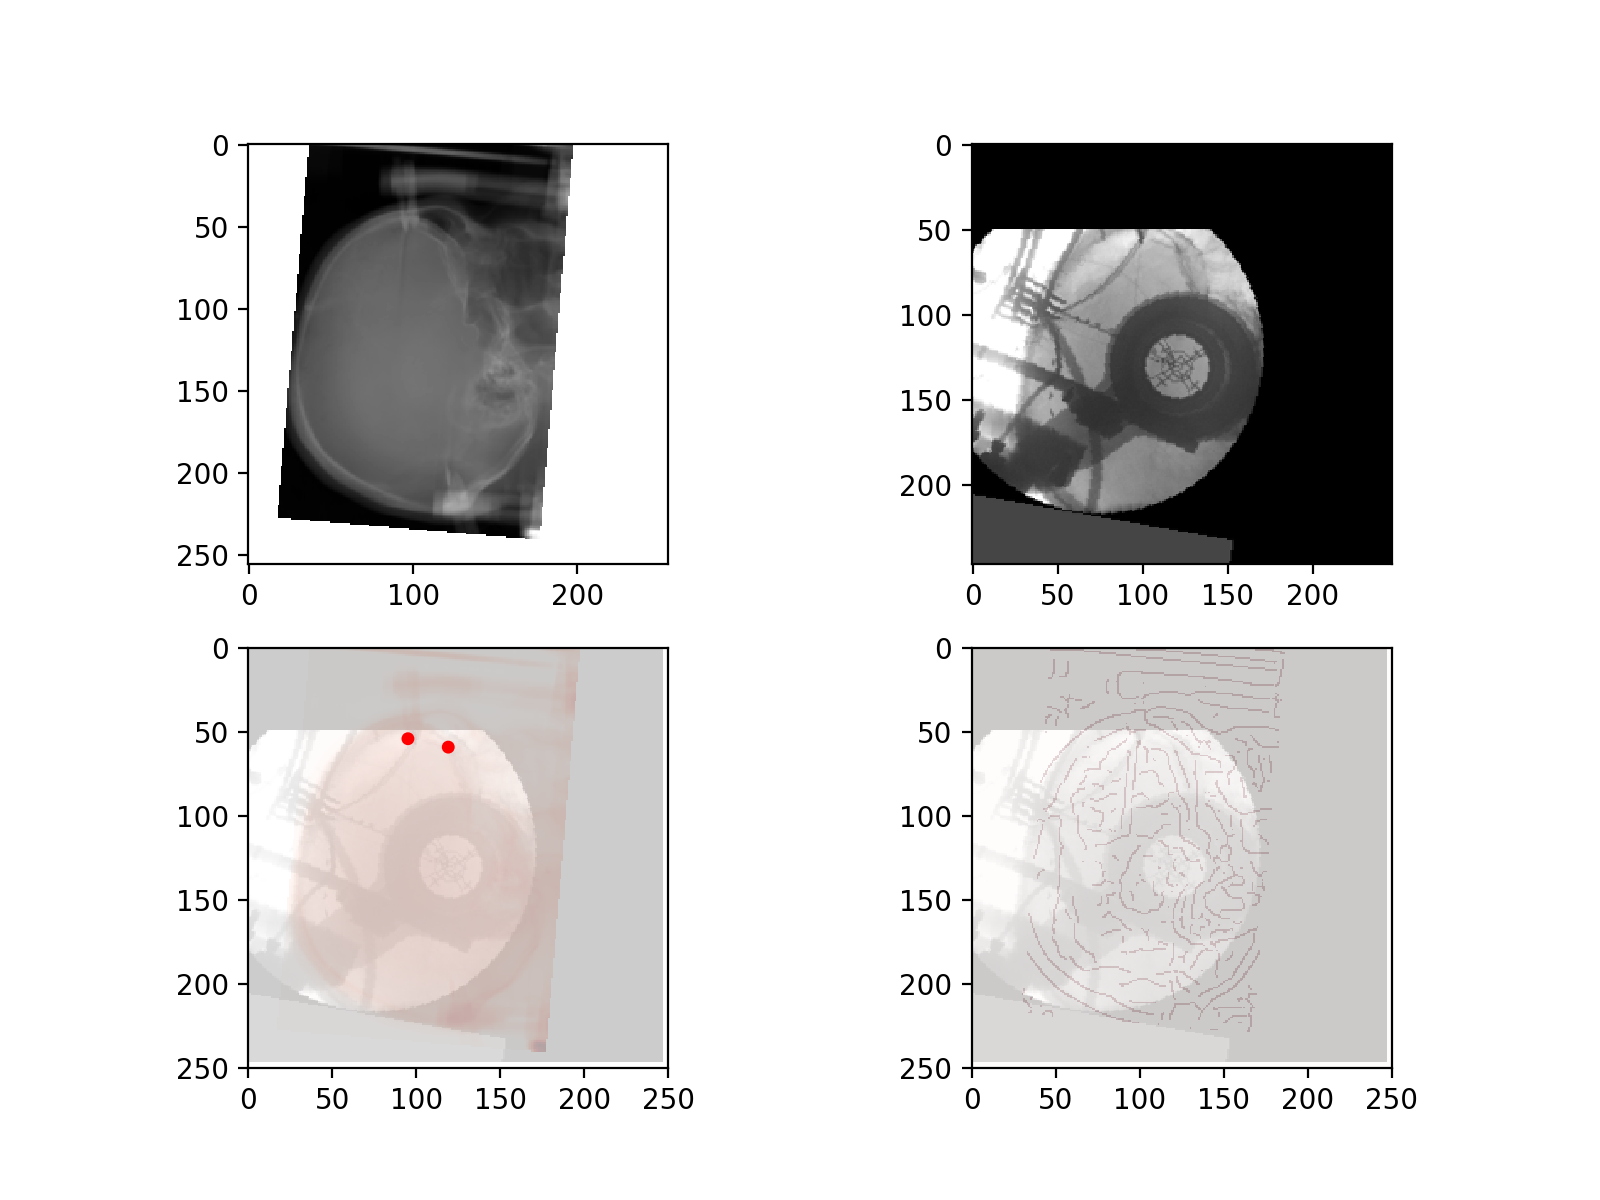

front pin tip 5.656854249492381
front bottom curve of skull 6.0


<IPython.core.display.Javascript object>


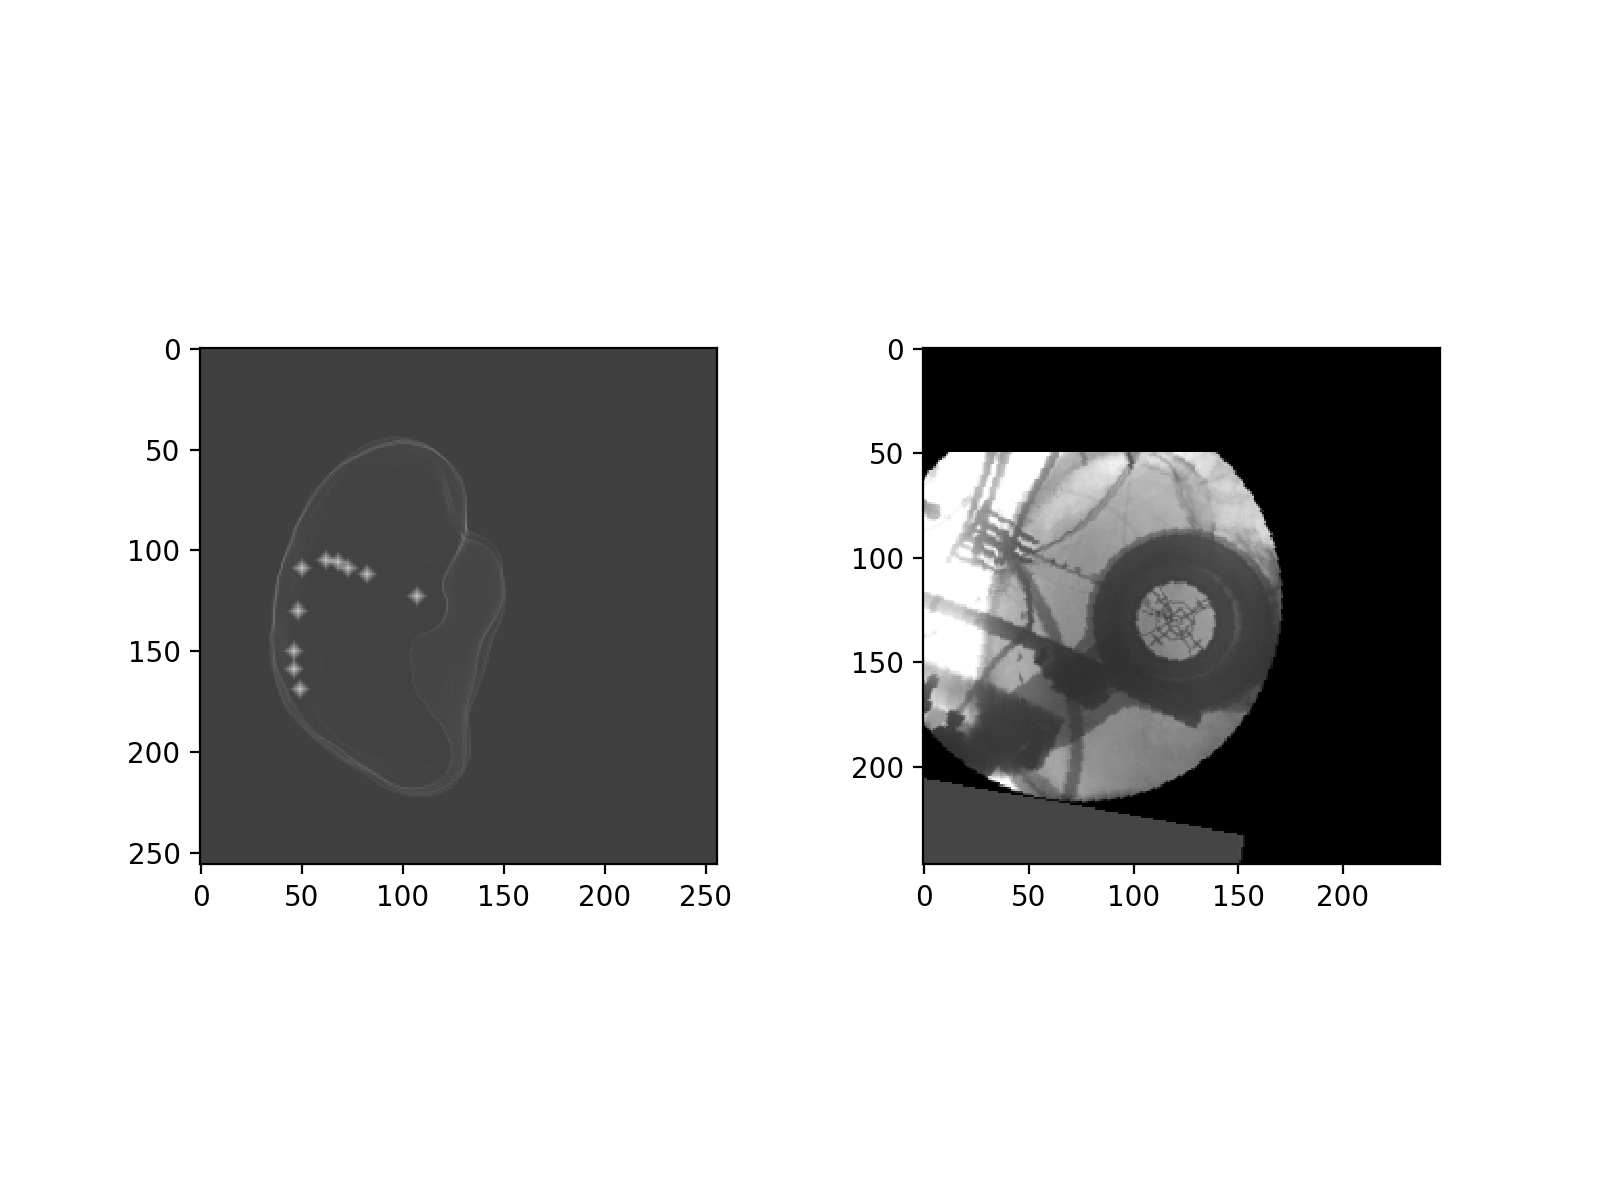

In [448]:
plot_preopt_fluoro("../data/subject_4/preopCT_subject_4.nii", "../data/subject_4/postopCT_subject_4.nii", "../data/subject_4/fluoro_subject_4.jpg")
reg_coords = [(54, 95), (69, 130), (572, 1114), (769, 1124)]
print(get_scale_resize(reg_coords, (1280, 1024)))

tr = Transform(size=(247, 197), rotate=80, shiftleft=50, shiftdown=0)
register(
    "../data/subject_4/preopCT_subject_4.nii",
    "../data/subject_4/fluoro_subject_4.jpg",
    tr,
    [(54, 95), (59, 119)]
)
electrodes = {
    "left": [(169, 49), (159, 46), (150, 46), (130, 48), (109, 50)],
    "right": [(123, 107), (112, 82), (109, 73), (106, 68), (105, 62)],
}
electrodes_arr = plot_electrodes("../data/subject_4/hull_subject_4.nii", electrodes, 5)
save_electrodes_arr(electrodes_arr, "../data/subject_4/electrodes.nii")
print("front pin tip", distance((54, 95), (58, 99)))
print("front bottom curve of skull", distance((65, 119), (59, 119)))
plot_hull_electrodes_fluoro(
    "../data/subject_4/hull_subject_4.nii",
    "../data/subject_4/electrodes.nii",
    "../data/subject_4/fluoro_subject_4.jpg",
    tr
)

(1280, 1024)


<IPython.core.display.Javascript object>


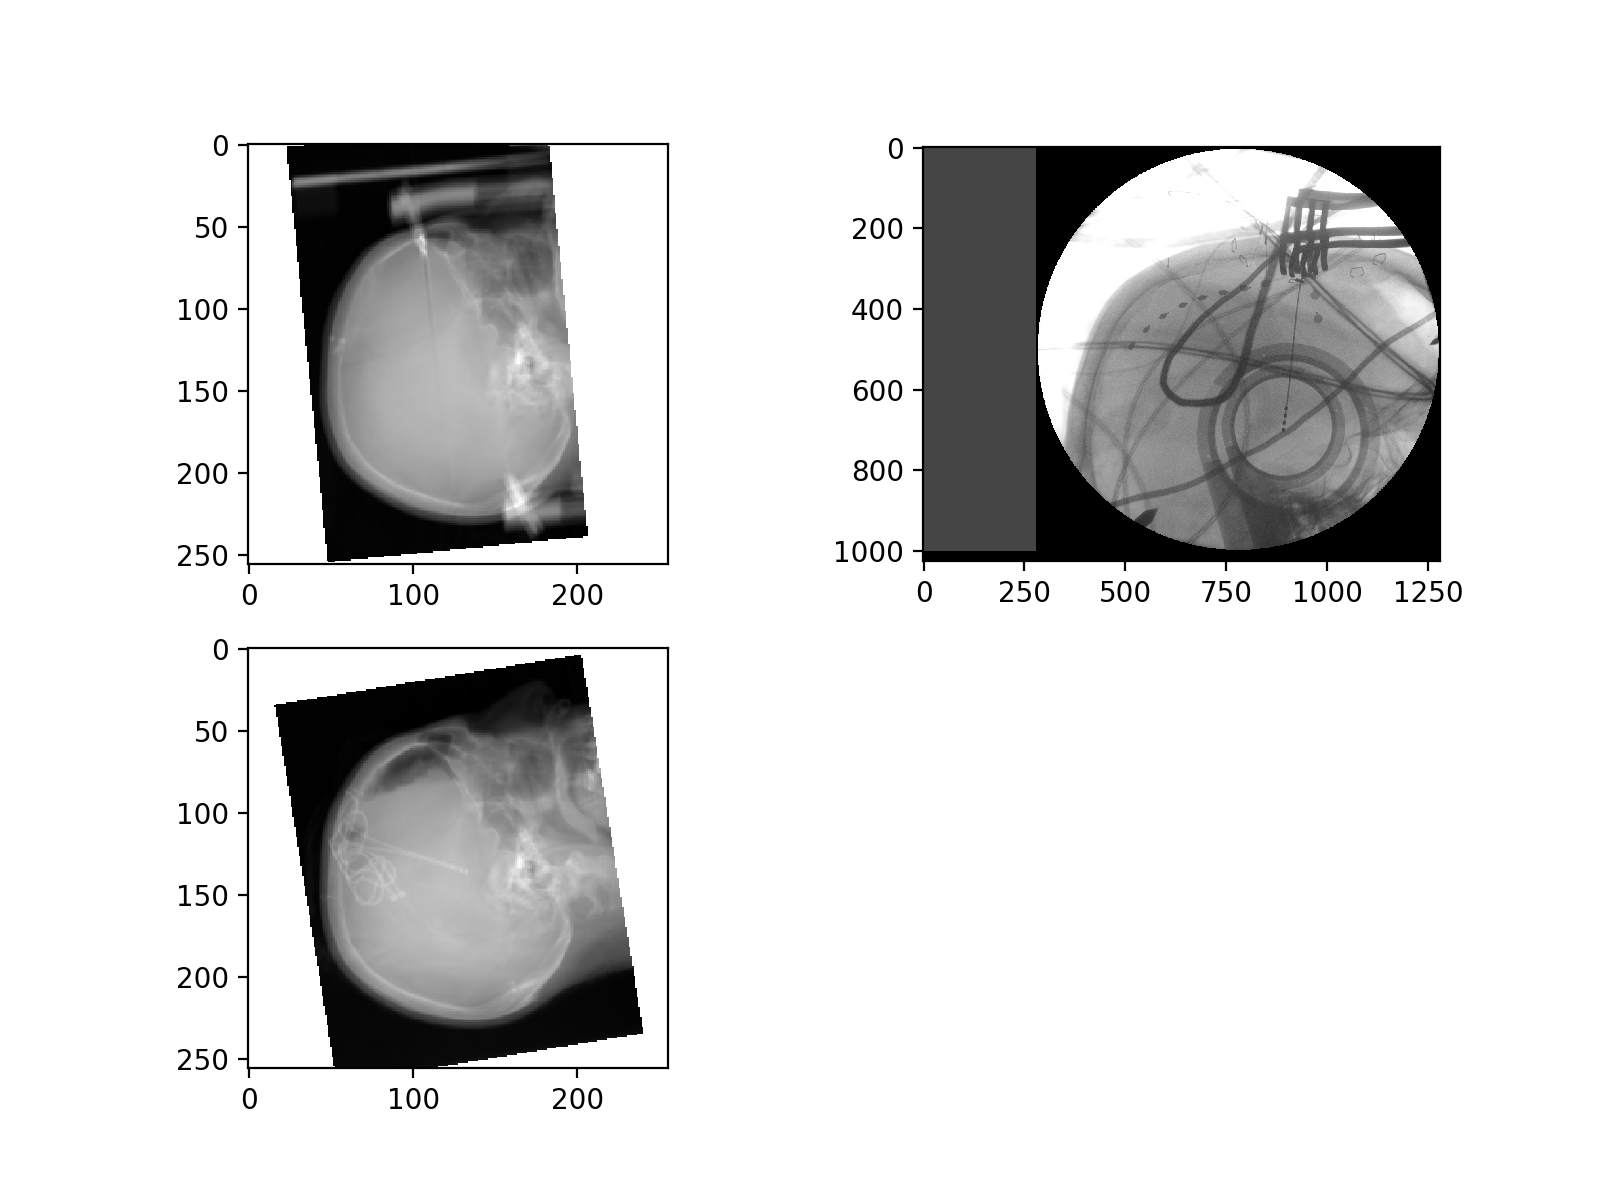

(0.18235003571144642, (233, 186))


<IPython.core.display.Javascript object>


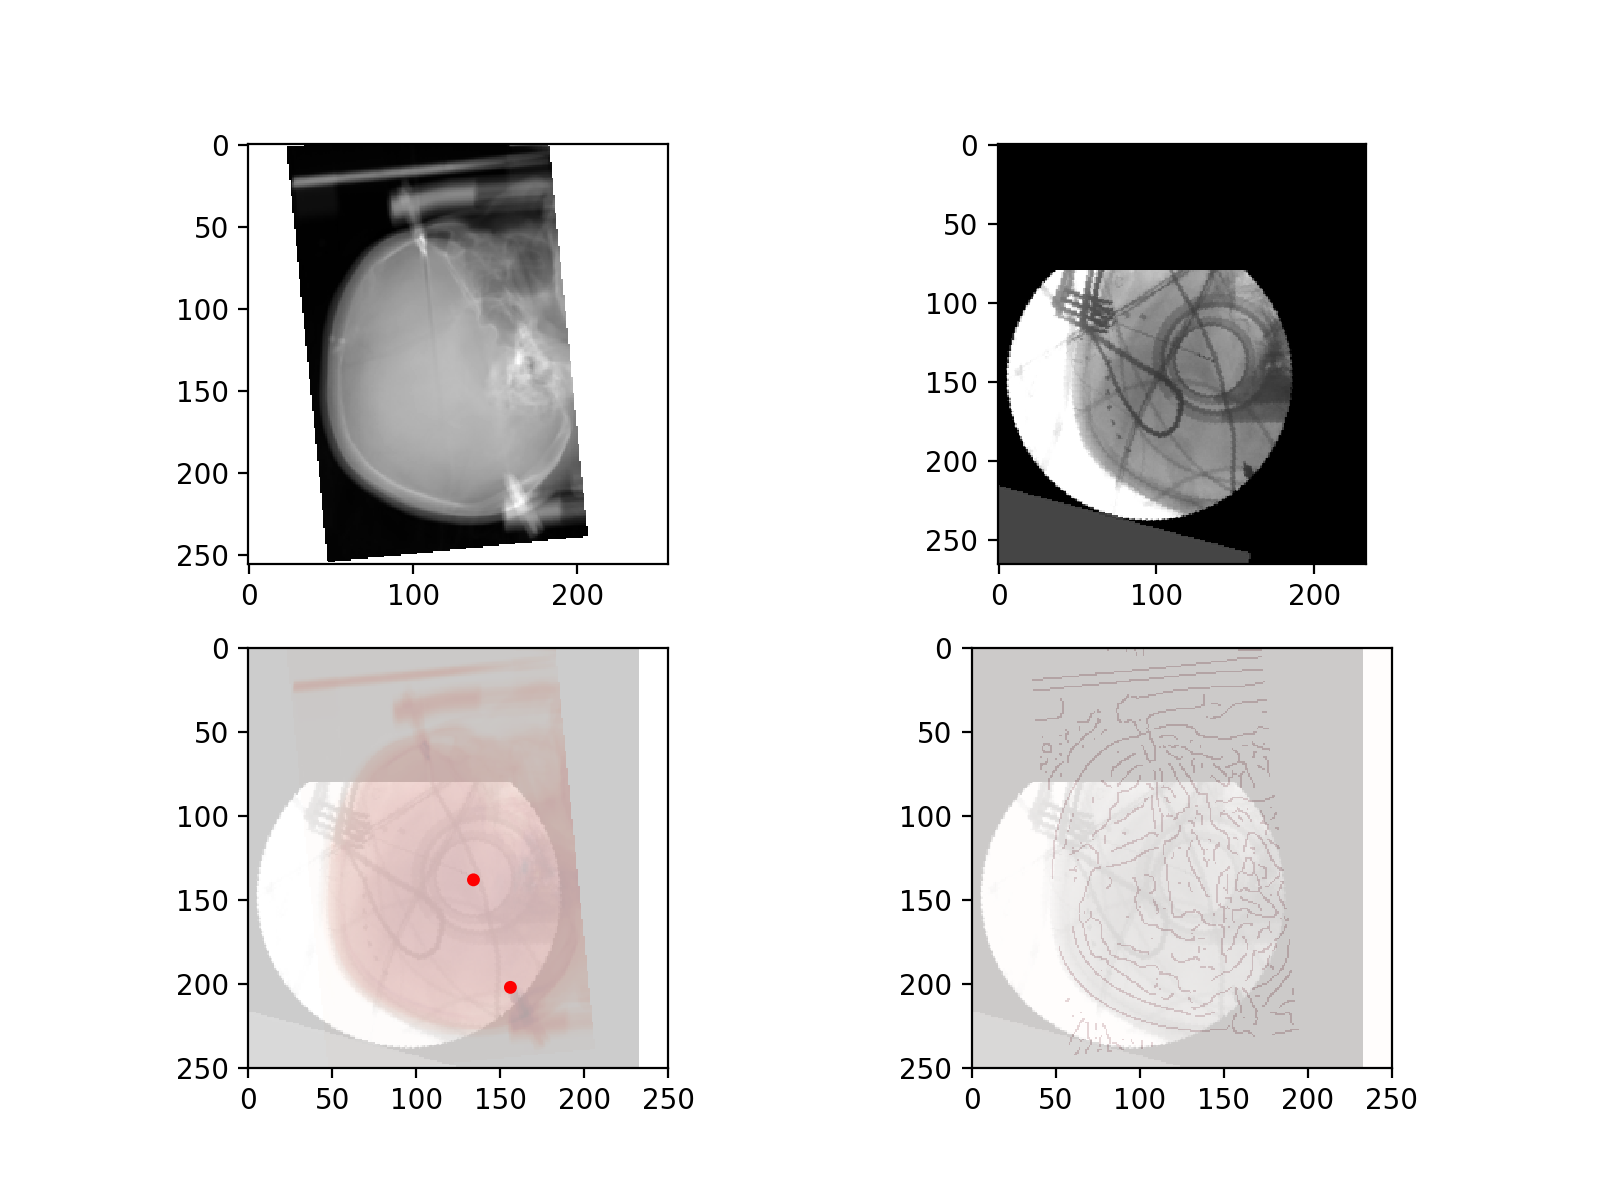

end of dbs electrode 3.1622776601683795
back pin tip 1.0


<IPython.core.display.Javascript object>


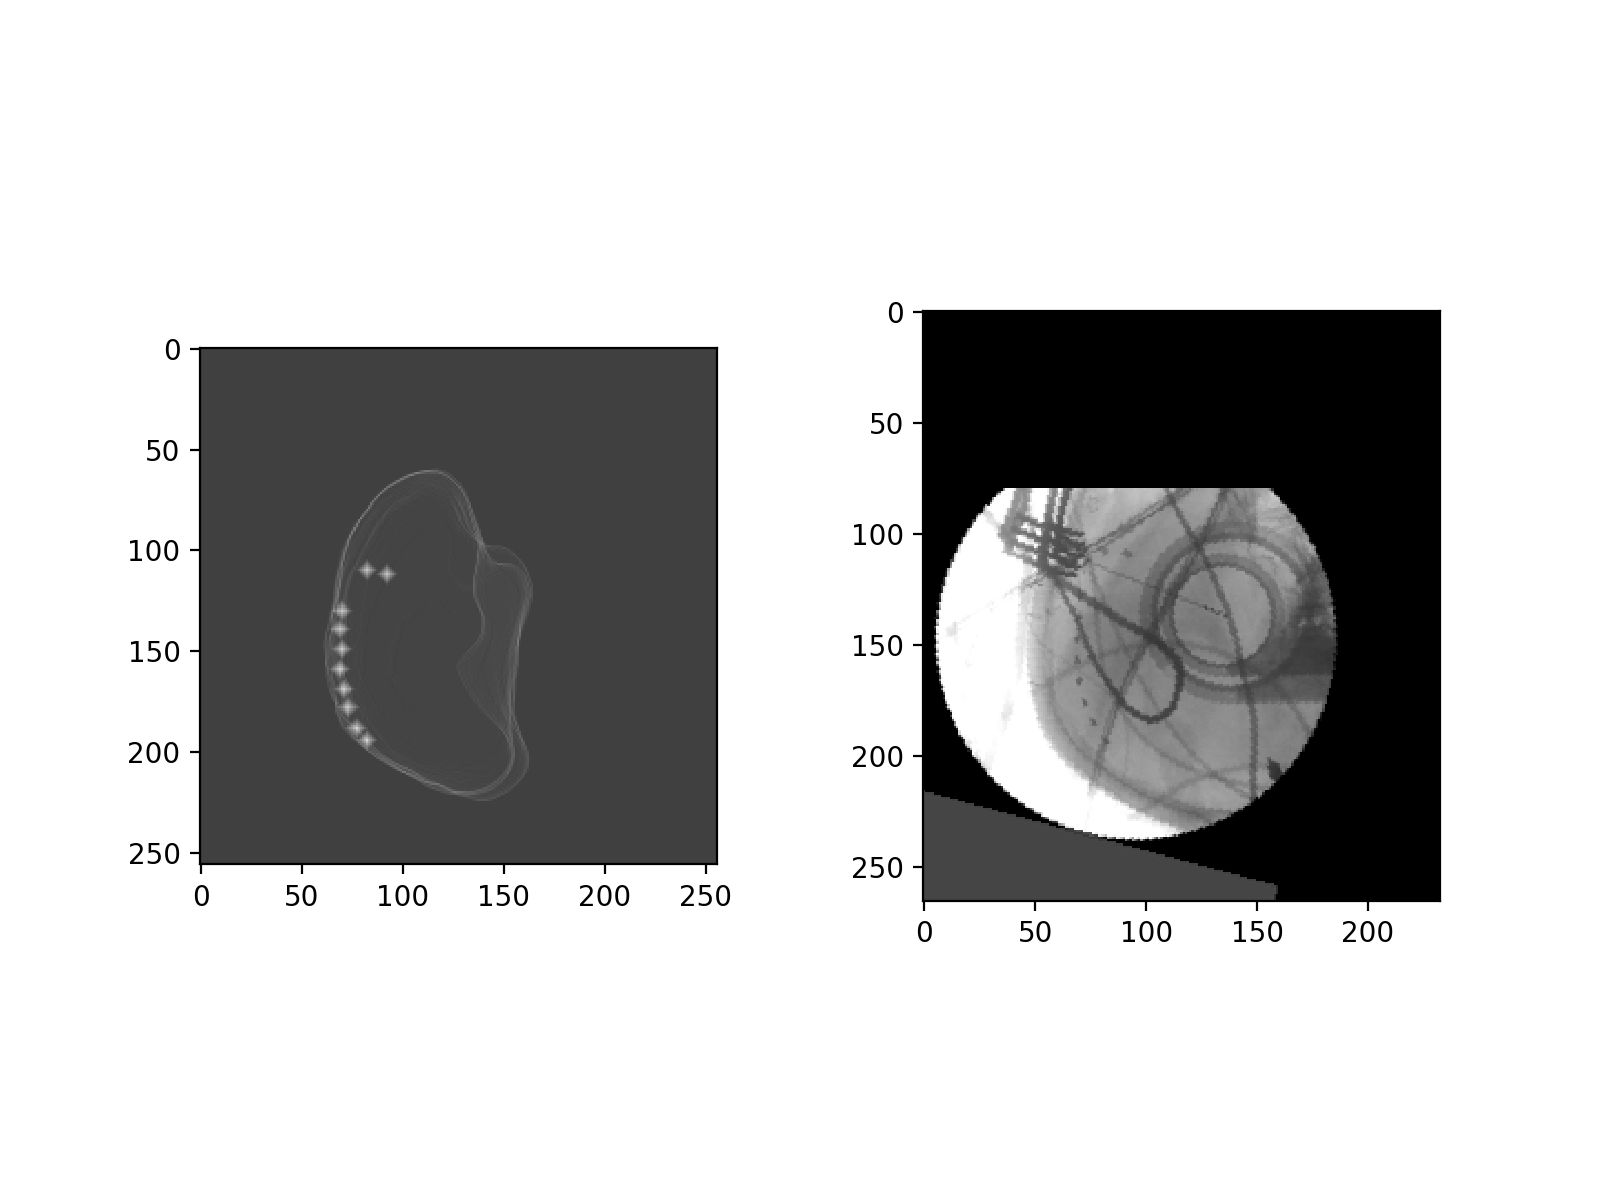

In [449]:
plot_preopt_fluoro("../data/subject_5/preopCT_subject_5.nii", "../data/subject_5/postopCT_subject_5.nii", "../data/subject_5/fluoro_subject_5.jpg")
reg_coords = [(202, 156), (138, 134), (904, 574), (711, 891)]
print(get_scale_resize(reg_coords, (1280, 1024)))

tr = Transform(size=(233, 286), rotate=75, shiftleft=25, shiftdown=55)
register(
    "../data/subject_5/preopCT_subject_5.nii",
    "../data/subject_5/fluoro_subject_5.jpg",
    tr,
    [(202, 156), (138, 134)],
)
electrodes = {
    "left": [(194, 82), (188, 77), (178, 73), (169, 71), (159, 69), (149, 70), (139, 69), (130, 70)],
    "right": [(112, 92), (110, 82)],
}
electrodes_arr = plot_electrodes("../data/subject_5/hull_subject_5.nii", electrodes, 5)
save_electrodes_arr(electrodes_arr, "../data/subject_5/electrodes.nii")
print("end of dbs electrode", distance((138, 134), (139, 137)))
print("back pin tip", distance((202, 156), (203, 156)))
plot_hull_electrodes_fluoro(
    "../data/subject_5/hull_subject_5.nii",
    "../data/subject_5/electrodes.nii",
    "../data/subject_5/fluoro_subject_5.jpg",
    tr
)

<IPython.core.display.Javascript object>


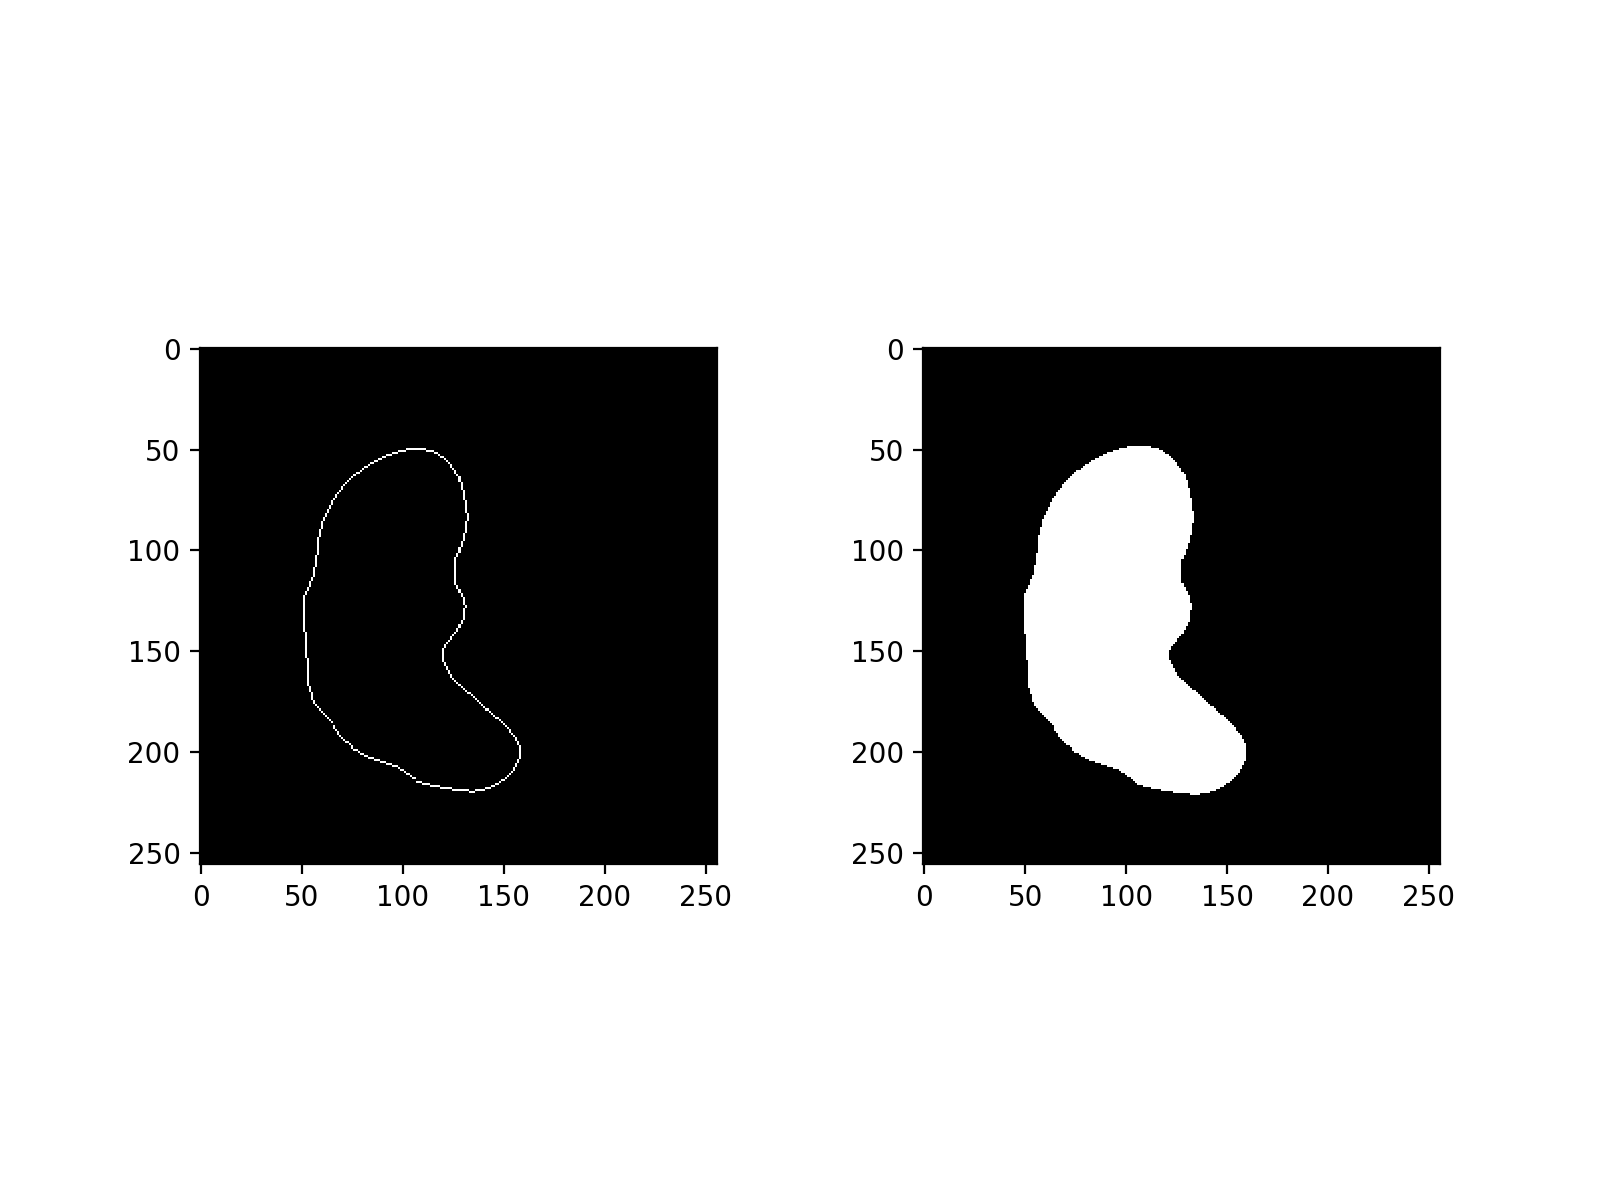

In [423]:
plot_hull_slices("../data/subject_1/hull_subject_1.nii", 92)